# **Install Required Packages**

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00


In [2]:
!pip install gensim==4.1.2 scipy==1.7.3 torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 50.9 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-4.1.2-cp310-cp310-linux_x86_64.whl size=25996679 sha256=2fc9f5dd068b1def5930f3285bce97dd045d8e9f356020a243596c4d1ff459b2
  Stored in directory: /root/.cache/pip/wheels/13/35/4e/dca2954de21981d0a137ff930239f0767403a617e32f19f04f
Successfully built gensim
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.3
    Uninstalling gensim-4.3.3:
      Succes

In [3]:
# Step 1: Import libraries
import os
import glob
import yaml
import csv
import numpy as np
import pandas as pd
import torch
import networkx as nx
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Data, HeteroData
from networkx.readwrite import json_graph
# Uncomment the following lines if these modules are part of your project
# from extractElements import extractElements
# from create_graph import CreateGraph
# from load_yml import ModelConfigLoader
# from GCN_GAT import GCN, GAT
# from gensim.models import Word2Vec


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Check if GPU is available**

In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


graph to data & data to graph

In [5]:
edge_types = []



class Node:
  def __init__(self, filename):
    self.data, self.attributes = self.load_data(filename)

  def load_data(self, filename):
    df = pd.read_csv(filename)
    filename = Path(filename).name
    node_type = filename.rsplit("_", 1)[0]
    src = node_type.split("_")[0]
    id_col = f"{src}Id"
    attributes = df[list(df.columns)[1:]]
    data = df[[id_col, 'graphNumber']]
    return data, attributes

class Edge:
  def __init__(self, filename):
    self.data, self.attributes = self.load_data(filename)

  def load_data(self, filename):
      df = pd.read_csv(filename)
      filename = Path(filename).name
      edge_type = filename.rsplit("_", 1)[0]

      # edge_type = Path(filename).rsplit("_", 1)[0]

      m = re.match(r"^(.*)_(.*)$", edge_type)
      if m:
          parts = m.groups()
      else:
          raise ValueError(...)

      src = parts[0]
      dst = parts[1]

      src_col = f"sr{src}Id"
      dst_col = f"ds{dst}Id"
      attributes = list(df.columns)[2:]
      data = df[[src_col, dst_col]]
      return data, attributes
class CreateGraph:
    def __init__(self, data_path, filters):
        self.nodes = {}
        self.edges = {}
        self.filters = filters
        self.metamodel_config = []


        node_files = self.get_node_files(data_path)
        for file in node_files:
            filename = Path(file).name
            node_type = filename.rsplit("_", 1)[0]

            # edge_type = file?name.rsplit("_", 1)[0]
            self.nodes[node_type] = Node(file)

        edge_files = self.get_edge_files(data_path)
        for file in edge_files:
            filename = Path(file).name
            edge_type = filename.rsplit("_", 1)[0]
            self.edges[edge_type] = Edge(file)
        self.edit_data()


    #edit nodes and edges data according ti Yaml file
    def edit_data(self):
        nodes_copy = self.nodes.copy()
        edges_copy = self.edges.copy()


        for node_type, node in nodes_copy.items():
            include = self.filters.get("classes").get("include")

            exclude = self.filters.get("classes").get("exclude")
            if (include is not None and node_type not in include) or (exclude is not None and node in exclude):
                del self.nodes[node_type]

            # include or exclude the attributes of classes
            # By Default, the attributes of nodes are not considered
            # But they are considered if includeAllAttributes = true

            if self.filters.get("classes").get("includeAllAttributes") == False or self.filters.get("classes").get("excludeAllAttributes") == True:
                if self.nodes.get(node_type) is not None:
                    self.nodes[node_type].attributes = []

        for edge in edges_copy:
            # print("edges", edge)
            edge_type_parts = edge.split("_")
            source_node=edge_type_parts[0]
            destination_node = edge_type_parts[1]
            if include is not None and (source_node and destination_node) not in include:
                del self.edges[edge]
            if exclude is not None and (source_node or destination_node) in exclude:
                del self.edges[edge]


    def get_node_files(self, data_path):
        return glob.glob(f"{data_path}/nodes/*.csv")

    def get_edge_files(self, data_path):
        return glob.glob(f"{data_path}/edges/*.csv")

    def get_edge_type(self, filename):
        return Path(filename).stem

    def onehot_encode(self, encoding, col, value):
        unique = list(encoding[col]["unique_values"])
        num_rows = len(unique)

        # Reshape based on number of rows
        unique = np.reshape(unique, (num_rows, 1))

        encoder = OneHotEncoder()
        encoder.fit(unique)
        val = np.array(value)

        val = val.reshape(1, -1)
        new_val = encoder.transform(val).toarray()
        return new_val

    def word2vec_encode(self, encoding, col, value):
        unique_names = encoding[col]["unique_values"]
        names = [[word] for word in unique_names]
        modelnamestates = Word2Vec(names, min_count=1)
        modelnamestates.save('word2vec.modelnamestate')
        import gensim
        modelnamestates = gensim.models.Word2Vec.load('word2vec.modelnamestate')
        all_embeddings_namestates = {}
        for word in unique_names:
            if word in modelnamestates.wv:
                embedding = modelnamestates.wv[word]
                all_embeddings_namestates[word] = embedding

        new_val = all_embeddings_namestates[value]
        return new_val

    def worde4mde (self, value):
        sgram_mde = load_embeddings('sgram-mde')
        new_val = sgram_mde[value]
        return new_val

    def model2heterograph(self) -> HeteroData:
        graphs = {}
        # data = HeteroData()

        for node_type, node in self.nodes.items():
            encoding = {}
            # unique_values = set()
            columns = list(node.attributes)
            for column in columns:
                if self.filters.get('classes', {}).get(node_type, {}).get('features', {}).get(column, {}).get(
                        'encoding') is not None:
                    encoding[column] = {}
                    encoding[column]["enc_type"] = self.filters.get('classes', {}).get(node_type, {}).get('features',
                                                                                                          {}).get(
                        column, {}).get(
                        'encoding')
                    unique_values = set(node.attributes[column])
                    encoding[column]["unique_values"] = unique_values
            for _, row in node.data.iterrows():
                graphNum = row["graphNumber"]
                if graphs.get(graphNum) is None:
                    G = HeteroData()
                    graphs[graphNum] = G
                else:
                    G = graphs[graphNum]

                id = node_type.split("_")[0]
                attr_dict = {}

                for col in node.attributes.columns:
                    for val in node.attributes[col]:
                        if encoding.get(col) is not None:
                            if encoding[col]["enc_type"] == "one-hot":
                                new_val = self.onehot_encode(encoding,col, val)
                            if encoding[col]["enc_type"] == "word2vec":
                                new_val= self.word2vec_encode(encoding, col, val)
                            if encoding[col]["enc_type"] == "worde4mde":
                                new_val = self.worde4mde(val)
                            val = new_val
                        attr_dict[col] = val
                G[node_type].x = attr_dict

        for edge_type, edge in self.edges.items():
            for _, row in edge.data.iterrows():
                src = edge_type.split("_")[0]
                dst = edge_type.split("_")[1]
                G[edge_type].edge_index = self.get_edge_index(edge.data, src, dst)
                G[edge_type].attrs = edge.attributes

        for edge_type, edge in self.edges.items():
            src = edge_type.split("_")[0]
            dst = edge_type.split("_")[1]

            G[edge_type].edge_index = self.get_edge_index(edge.data, src, dst)
            # data[edge_type].edge_index = self.get_edge_index(edge.data)
            G[edge_type].attrs = edge.attributes


        return graphs

    def get_edge_index(self, edge_data, src, dst):
        src_col = f"sr{src}Id"
        dst_col = f"ds{dst}Id"
        return edge_data[[src_col, dst_col]].values

    def model2HomoGraph(self) -> nx.Graph:
        graphs = {}
        ids = {}


        # Add nodes
        for node_type, node in self.nodes.items():
            encoding = {}
            columns = list(node.attributes)
            for column in columns:
                if self.filters.get('classes', {}).get(node_type, {}).get('features', {}).get(column, {}).get(
                    'encoding') is not None:
                    encoding[column] = {}
                    encoding[column]["enc_type"] = self.filters.get('classes', {}).get(node_type, {}).get('features', {}).get(column, {}).get(
                    'encoding')
                    unique_values = set(node.attributes[column])
                    encoding[column]["unique_values"] = unique_values

            index = 0
            for _, row in node.data.iterrows():
                graphNum = row["graphNumber"]
                # Create graph if not exists
                if graphs.get(graphNum) is None:
                    G = nx.MultiDiGraph()
                    graphs[graphNum] = G
                    ids[graphNum] =0

                    # Create new graph
                    # Add to graphs list
                else:
                    # Get existing graph

                    G = graphs[graphNum]
                id = node_type.split("_")[0]
                nid = row[f"{id}Id"]
                node.data.loc[index, 'newId'] = ids[graphNum]
                index += 1
                newId = ids[graphNum]
                ids[graphNum] += 1

                G.add_node(newId)
                G.nodes[newId]['type'] = node_type
                for col in node.attributes.columns:
                    for val in node.attributes[col]:
                        if encoding.get(col) is not None:
                            if encoding[col]["enc_type"] == "one-hot":
                                new_val = self.onehot_encode(encoding,col, val)
                            if encoding[col]["enc_type"] == "word2vec":
                                new_val= self.word2vec_encode(encoding, col, val)
                            if encoding[col]["enc_type"] == "worde4mde":
                                new_val = self.worde4mde(val)

                                # new_val = new_val.reshape(1, -1)
                            val = new_val

                        G.nodes[newId][col] = val


        # Add edges
        for edge_type, edge in self.edges.items():

            for _, row in edge.data.iterrows():
                part1 = edge_type.split("_")[0]
                part2 = edge_type.split("_")[1]
                src = row[f"sr{part1}Id"]
                dst = row[f"ds{part2}Id"]

                newsrc = int(self.nodes[part1].data.loc[self.nodes[part1].data[f"{part1}Id"] == src, 'newId'].iloc[0])
                newdst = int(self.nodes[part2].data.loc[self.nodes[part2].data[f"{part2}Id"] == dst, 'newId'].iloc[0])

                graph_number =  self.nodes[part1].data.loc[self.nodes[part1].data[f"{part1}Id"] == src, 'graphNumber'].iloc[0]
                print("before:")
                print("g nodes:", G.nodes)
                graphs[graph_number].add_edge(newsrc, newdst)


        return graphs

# **Extract elements**

In [6]:
import csv
import glob
import os
from collections.abc import Iterable
# from org.eclipse.emf import ecore
# from pyecore.ecore import EAttribute
# from pyecore.ecore import EStructuralFeature
# from pyecore.ecore import EOrderedSet
# from pyecore.ecore import EClass

In [7]:
# from ecore import EAttribute

In [8]:
# import networkx as nx
import yaml
# from pyecore.ecore import EEnum
# from pyecore.resources import ResourceSet, URI


In [9]:
import csv
import os
class extractElements:
    case = "xmi"
    ecoreNumber = 0
    featureTypes = []
    graphNo = 0
    nodeLabel = 1
    Graphs = []
    attributeNames = {}
    classes = dict()
    directories = 1
    filenumber = 0
    yamlexistance = 0
    mapvalue = {}
    yamlcontents = {}
    referenceNames = {}
    IDs = {}
    graphAttributes = {}
    visitednodes = []
    jsondata = {}
    visited = []
    queue = []
    pathfile = None
    yamlFeatures = {}
    yamlclasses = {'include': [], 'exclude': []}
    modelData = {}
    csvData = {}
    refFeatures = []
    csvEdgesData = {}
    folder = ""
    ids = {}

    graphNumber = 0

    def __init__(self, models_path: str, metamodel_path:str):
        self.models_path = models_path
        self.metamodel_path = metamodel_path

        self.load_config()
        self.load_metamodel(metamodel_path)
        self.process_models(models_path)

        #check the format of input models in Yaml
    def load_config(self) -> None:

        self.current_dir = os.path.dirname(__file__)
        config_file = os.path.join(self.current_dir, 'config.yaml')
        with open(config_file) as f:
            self.yamlcontents = yaml.load(f, Loader=yaml.FullLoader)
        self.case = self.yamlcontents['inputmodels']['format']

    def load_metamodel(self, metamodel_path) -> None:
        rset = ResourceSet()
        resource = rset.get_resource(URI(metamodel_path))
        self.meta_root = resource.contents[0]

    def process_models(self, models_path) -> None:
        if self.case == "ecore":
            self.load_ecore_models(models_path)
        elif self.case == "xmi":
            self.load_xmi_models(models_path)
        self.create_edges()
        self.create_csv()

    def load_ecore_models(self, models_path):

        os.chdir(models_path)

        for file in glob.glob("*.ecore"):
            print("file is", file)
            ecore_file = os.path.join(models_path, file)

            self.rset = ResourceSet()
            resource = self.rset.get_resource(URI(ecore_file))
            model_root = resource.contents[0]

            self.ecoreNumber += 1
            self.create_nodes(model_root, self.meta_root)

    def load_xmi_models(self, models_path):

        os.chdir(models_path)

        self.rset.metamodel_registry[self.meta_root.nsURI] = self.meta_root

        for file in glob.glob("*.xmi"):
            xmi_file = os.path.join(models_path, file)

            resource = self.rset.get_resource(URI(xmi_file))
            model_root = resource.contents[0]

            self.filenumber += 1
            self.create_nodes(model_root, self.meta_root)



    def checkYaml(self, mmroot, model, elementType, case, element=None, ):
        print("checkyaml is", "mmroot=", mmroot, "model is=", model, "elementType=", elementType, "case=", case,
              "element=", element)
        metamodel_name = mmroot.name
        metamodel_nsURI = mmroot.nsURI
        modelName = model.eClass.name
        print("element is=", element)
        if element != None:
            elementName = element.name
        # print("model in checkyaml:", modelName)
        if self.yamlexistance == 0:
            print("yaml 0")
            return True
        elif case == "include" and elementType == "class":
            print("checking existance")

            print("meta name=", metamodel_name)
            print("ns is", metamodel_nsURI)
            print("modelName=", modelName)
            if ((self.deep_get(self.yamlcontents,
                               ['adaptations', 'metamodels', 'packages', metamodel_name,
                                'uri', mmroot.nsURI, 'classes',
                                'exclude']) != None and modelName in self.deep_get(
                self.yamlcontents,
                ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI, 'classes',
                 'exclude'])) or (self.deep_get(self.yamlcontents,
                                                ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri',
                                                 mmroot.nsURI, 'classes',
                                                 'include']) != None and modelName not in self.deep_get(
                self.yamlcontents,
                ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI, 'classes',
                 'include']))):
                print("model True")
                return False
            else:
                return True
        elif elementType == "feature" and case == "existance":
            print("here feature existance")
            if self.deep_get(self.yamlcontents,
                             ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI,
                              'classes', modelName, 'features', elementName, 'isIncluded']) != None:
                if self.deep_get(self.yamlcontents,
                                 ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI,
                                  'classes', modelName, 'features', elementName, 'isIncluded']) == "False":
                    print("return False1")
                    return False





            elif (self.deep_get(self.yamlcontents,
                                ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI,
                                 'classes', modelName, "include"]) != None and elementName not in self.deep_get(
                self.yamlcontents, ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI,
                                    'classes', modelName, "include"])):
                print("return False2")
                return False
            elif self.deep_get(self.yamlcontents,
                               ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI,
                                'classes', "excludeAllAttributes"]) == "True":
                print("return False3")
                return False
            else:
                print("return True")
                return True
        elif case == "renaming":
            print("yamlcontent::", self.yamlcontents)
            print("renaming")
            print("metaname:", metamodel_name)
            print("model", modelName)
            print("element:", elementName)
            print("rename value==", self.deep_get(self.yamlcontents,
                                                  ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri',
                                                   mmroot.nsURI,
                                                   'classes', modelName, 'features', elementName, 'renaming']))
            if self.deep_get(self.yamlcontents,
                             ['adaptations', 'metamodels', 'packages', metamodel_name, 'uri', mmroot.nsURI,
                              'classes', modelName, 'features', elementName, 'renaming']) != None:
                print("rename exists")
                return self.yamlcontents['adaptations']['metamodels']['packages'][metamodel_name]['uri'][mmroot.nsURI][
                    'classes'][modelName]['features'][elementName]['renaming']
            else:

                return True

    def deep_get(self, d, keys):
        if not keys or d is None:
            return d
        return self.deep_get(d.get(keys[0]), keys[1:])

    model_data = {}
    attribute_types = []

    def create_nodes(self, model, mmroot):
        print("creating nodes")
        self.graphNumber = self.graphNumber + 1
        print("graphNumber issss:", self.graphNumber)
        # Data structures
        self.model_data = {}
        self.attribute_types = []

        # Create node data for root model

        node_data = self.create_node_data(model, mmroot, self.graphNumber)


        # Add root node data to model data
        self.add_to_model_data(model, node_data)

        # Process child elements
        for element in self.get_child_elements(model):
            print("child element")
            # Create node data for child

            child_node_data = self.create_node_data(element, mmroot, self.graphNumber)

            # Add child node data to model data
            self.add_to_model_data(element, child_node_data)

        # Return data structures
        return self.model_data, self.attribute_types

    def create_node_data(self, element, mmroot, graphNo):
        print("creating node data")

        graphdata = {}
        graphcsvdata = {}

        # metamodel_name = mmroot.name
        # modelName = element.eClass.name

        node_number = 0
        if element.eClass.name in self.ids:
            node_number = self.ids[element.eClass.name] + 1

        self.ids[element.eClass.name] = node_number

        for feature in element._isset:


            feature_name = feature.name
            feature_value = element.eGet(feature)

            graphdata[feature_name] = feature_value
            # print("graphNo is now:", graphNo)
            graphdata["graphNumber"] = graphNo
            graphcsvdata["graphNumber"] = graphNo

            if not feature.is_reference:
                graphcsvdata[feature_name] = feature_value

            if feature.is_attribute:

                types = {}
                types["node"] = element.eClass.name
                types["name"] = feature.name
                print("ids is:", self.ids)
                print("element is", element)
                types["nodeNumber"] = self.ids[element.eClass.name]
                # node_number = self.ids.get(class_name, 0) + 1

                if isinstance(feature.eType, EEnum):
                    types["type"] = "EString"
                else:
                    types["type"] = feature.eType.name

                self.featureTypes.append(types)
                types = {}

        self.modelData.setdefault(element.eClass.name, []).append(graphdata)
        self.modelData[element.eClass.name][-1]["element"] = element

        self.csvData.setdefault(element.eClass.name, []).append(graphcsvdata)


        return graphdata



    def get_node_number(self, element):
        print("csvdata", self.csvData)
        print(" modeldata", self.modelData)
        class_name = element.eClass.name

        node_number = self.ids.get(class_name, 0) + 1

        self.ids[class_name] = node_number

        return node_number

    def add_to_model_data(self, element, data):
        print("add to model data")


        self.model_data.setdefault(element.eClass.name, []).append(data)
        data["element"] = element

    def get_child_elements(self, element):

        return element.eAllContents()

    def get_eclass(self, element, mmroot):

        return mmroot.getEClassifier(element.eClass.name)

    def get_features(self, eclass):

        return list(eclass.eStructuralFeatures)



    def create_edges(self):
        print("Creating edges...")
        for keys in self.csvData:
            for i in range(0, len(self.csvData[keys])):
                        id = str(keys) + "Id"
                        self.csvData[keys][i][id] = i
                        self.modelData[keys][i][id] = i

        reference_properties = {"eClassifiers", "ePackage", "eStructuralFeatures", "eType",
                        "eContainingClass", "eOpposite", "eSuperTypes", "eModelElement"}

        for node_type, nodes in self.modelData.items():
            # print("nodes is", nodes)
            for node in nodes:

                for property, references in node.items():
                    if property in reference_properties:

                        # print("references", references)
                        if isinstance(references, Iterable):
                            # print("yes iterable")
                            refs = list(references)
                        else:
                            refs = [references]

                        source_id = node[f"{node_type}Id"]
                        graph_number = node["graphNumber"]
                        # print("references", refs)
                        for reference in refs:

                            edge_type = reference.eClass.name

                            if self.csvEdgesData.get(f"{node_type}_{edge_type}") is None:
                                self.csvEdgesData[f"{node_type}_{edge_type}"] = []
                            # print("edge type", edge_type)
                            # print("model data:", self.modelData)
                            if edge_type in self.modelData:

                                for dest_node in self.modelData[edge_type]:

                                    if ("element", reference) in dest_node.items() and (
                                    dest_node["graphNumber"], graph_number):
                                        dest_id = dest_node[f"{edge_type}Id"]

                                        edge_data = {}
                                        edge_data[f"sr{node_type}Id"] = source_id
                                        edge_data[f"ds{edge_type}Id"] = dest_id
                                        edge_data["name"] = property

                                        self.csvEdgesData[f"{node_type}_{edge_type}"].append(edge_data)



    def create_csv(self):



        print("Creating CSV files...")

        # Encapsulate node logic
        self._write_nodes_csv()

        # Encapsulate edges logic
        self._write_edges_csv()

        # Encapsulate types logic
        self._write_types_csv()

        print("CSV files created!")



    def _write_nodes_csv(self):
        for types, records in self.csvData.items():
            self._write_to_csv(records, types, "nodes")

    def _write_edges_csv(self):
        for types, records in self.csvEdgesData.items():
            if records:
                self._write_to_csv(records, types, "edges")

    def _write_types_csv(self):
        print("feature types:", self.featureTypes)
        self._write_to_csv(self.featureTypes, "types", folder="types")

    def _write_to_csv(self, records, types, folder):
        if types == "types":
            filename = f"{types}"
        else:
            filename = f"{types}_{folder}"
        dir_path = f"..\\csvfiles\\{folder}"

        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)

        fields = records[0].keys()

        with open(os.path.join(dir_path, f'{filename}.csv'), 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fields, extrasaction='ignore')
            writer.writeheader()

            writer.writerows(records)

# visualize graph

In [58]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import graphviz

class GraphVisualizer:
    def __init__(self, G):
        self.G = G

    def get_map_attention(self, atts):
        return {n: atts[i].detach().cpu().numpy() for i, n in enumerate(self.G.nodes())}

    def get_colors(self, map_colors):
        low, *_, high = sorted(map_colors.values())
        norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
        mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
        return {n: '#%02x%02x%02x' % tuple(mapper.to_rgba(c, bytes=True)[:3]) for n, c in map_colors.items()}

    def heat_map(self, atts, filename, directory, ignore=[]):
        g = graphviz.Digraph(filename)
        colors = self.get_colors(self.get_map_attention(atts))
        for e in self.G.edges(data=True):
            if any(kw in e[2]['type'] for kw in ignore):
                continue
            for node in e[:2]:
                g.node(str(node), label=self.G.nodes[node]['type'],
                       color=colors[node], style='filled', fillcolor=colors[node])
            g.edge(str(e[0]), str(e[1]), label=e[2]['type'])
        g.format, g.directory = 'pdf', directory
        g.view()

In [59]:
# Create a sample graph
G = nx.Graph()
G.add_nodes_from('/content/MetaModel_EXTRA/csvfiles/nodes') # change location
G.add_edges_from([(0, 1, {'type': 'edge_type_1'}), (1, 2, {'type': 'edge_type_2'})])#change location

# Create an instance of GraphVisualizer
visualizer = GraphVisualizer(G)

# # Example usage of methods

# early stopping

In [60]:
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, mode='min', path='checkpoint.pth'):
        self.patience, self.min_delta, self.mode = patience, min_delta, mode
        self.best, self.num_bad_epochs = None, 0
        self.is_better = (lambda a, b: a < b - min_delta) if mode == 'min' else (lambda a, b: a > b + min_delta)
        self.path = path

    def step(self, metrics, model, epoch):
        if self.best is None or self.is_better(metrics, self.best):
            self.best, self.num_bad_epochs = metrics, 0
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'metrics': metrics}, self.path)
        else:
            self.num_bad_epochs += 1
        return self.num_bad_epochs >= self.patience

In [62]:
import torch.optim as optim
import torch.nn as nn

# Example model and optimizer
model = nn.Linear(10, 2)  # Replace with your model
optimizer = optim.Adam(model.parameters())

# Initialize EarlyStopping with the corrected parameters
early_stopping = EarlyStopping(patience=5, min_delta=0.01, mode='min', path='checkpoint.pth')

# Simulated training loop
for epoch in range(100):
    # Assume you have some validation metric to monitor, such as validation loss
    val_loss = 0.1  # Replace with actual validation loss value

    # Check for early stopping
    if early_stopping.step(val_loss, model, epoch):  # Pass model and epoch within the loop
        print("Early stopping triggered")
        break

Early stopping triggered


# **Enhancements and Next Steps**

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Extract the ZIP File**

In [64]:
import os
import zipfile

# Path to your zip file on Google Drive
zip_file_path = '/content/drive/MyDrive/gnnmodel/metamodel.zip'
extract_to = '/content/MetaModel_EXTRA'

# Ensure the extraction directory exists
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("File extracted successfully!")


File extracted successfully!


# **Load and Parse the YAML Configuration**

In [65]:
# load yml

import yaml

class ModelConfigLoader:
    def __init__(self, config_path: str):
        self.config_path = config_path
        self.config = None
        self.model_type = None
        self.hidden_layers = None
        self.layer_dims = None
        self.activation_function = None
        self.learning_rate = None
        self.optimizer_type = None
        self.epochs = None
        self.batch_size = None
        self.use_node_features = None
        self.use_edge_features = None
        self.dropout = None
        self.train_test_split = None
        self.output_model_path = None

    def load_config(self):
        # Load the YAML configuration file
        with open(self.config_path, 'r') as file:
            self.config = yaml.safe_load(file)

        # Extract parameters from the loaded configuration
        self.model_type = self.config['model_type']
        self.hidden_layers = self.config['hidden_layers']
        self.layer_dims = self.config['layer_dimensions']
        self.activation_function = self.config['activation_function']

        self.learning_rate = self.config['learning_rate']
        self.optimizer_type = self.config['optimizer']
        self.epochs = self.config['epochs']
        self.batch_size = self.config['batch_size']
        self.use_node_features = self.config['use_node_features']
        self.use_edge_features = self.config['use_edge_features']
        self.dropout = self.config['dropout']
        self.train_test_split = self.config['train_test_split']
        self.output_model_path = self.config.get('output_model_path', './saved_model.pth')  # Default path

    def get_config(self):
        if self.config is None:
            raise ValueError("Configuration has not been loaded. Call 'load_config()' first.")
        return {
            'model_type': self.model_type,
            'hidden_layers': self.hidden_layers,
            'layer_dims': self.layer_dims,
            'activation_function': self.activation_function,
            'learning_rate': self.learning_rate,
            'optimizer_type': self.optimizer_type,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'use_node_features': self.use_node_features,
            'use_edge_features': self.use_edge_features,
            'dropout': self.dropout,
            'train_test_split': self.train_test_split,
            'output_model_path': self.output_model_path
        }


# **Define the GCN and GAT Models**

In [18]:
!pip install torch_geometric

In [66]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GNNWithAttention(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNWithAttention, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.pool = global_mean_pool
        self.fc = torch.nn.Linear(hidden_channels * 4, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.pool(x, data.batch)
        return F.log_softmax(self.fc(x), dim=1)


In [67]:
from torch_geometric.nn import GATConv
# Define the GAT model
class GAT(nn.Module):
    def __init__(self, num_layers, layer_dims, activation_func):
        super(GAT, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = getattr(nn, activation_func)()

        for i in range(num_layers):
            in_dim = layer_dims[i] if i == 0 else layer_dims[i - 1]
            out_dim = layer_dims[i]
            self.layers.append(GATConv(in_dim, out_dim))

    def forward(self, x, edge_index):
        for layer in self.layers:

            x = layer(x, edge_index)
            x = self.activation(x)
        return x

# **Graph Generation (New Component)**

In [68]:
# Graph Decoder to generate new graphs from latent embeddings
class GraphDecoder(torch.nn.Module):
    def __init__(self, latent_dim, num_node_features, num_nodes):
        super(GraphDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_node_features = num_node_features
        self.num_nodes = num_nodes

        # A decoder that maps the latent embedding back to node features
        self.fc = nn.Linear(latent_dim, num_nodes * num_node_features)  # Create node features from latent embedding

    def forward(self, latent_embedding):
        # Decode latent embedding into node features
        decoded_node_features = self.fc(latent_embedding)
        decoded_node_features = decoded_node_features.view(self.num_nodes, self.num_node_features)

        # Generate a random edge index (this part can be modified for specific use-cases)
        edge_index = torch.randint(0, self.num_nodes, (2, self.num_nodes * 2))  # Example edge generation

        return decoded_node_features, edge_index


# **Training the Model with Graph Generation**

In [69]:
# Define the complete GNN Autoencoder model
class GNN_Autoencoder(torch.nn.Module):
    def __init__(self, gcn_encoder, graph_decoder):
        super(GNN_Autoencoder, self).__init__()
        self.encoder = gcn_encoder
        self.decoder = graph_decoder

    def forward(self, x, edge_index):
        # Encode the graph into a latent representation
        node_embeddings, latent_embedding = self.encoder(x, edge_index)

        # Decode the latent representation to generate a new graph
        decoded_node_features, decoded_edge_index = self.decoder(latent_embedding)

        return decoded_node_features, decoded_edge_index


# **Graph-to-Model Conversion (Reverse Process)**

In [70]:
class CreateGraph:
    # Add a reverse function that maps generated graphs back into model format
    def graph_to_model(self, graphs):
        models = []
        for graph_num, G in graphs.items():
            model = {}  # Dictionary to hold the model structure

            for node in G.nodes(data=True):
                node_id, node_attrs = node
                node_type = node_attrs['type']

                # Map graph nodes to model classes
                if model.get(node_type) is None:
                    model[node_type] = []
                model[node_type].append(node_attrs)

            for edge in G.edges(data=True):
                src, dst, edge_attrs = edge
                src_type = G.nodes[src]['type']
                dst_type = G.nodes[dst]['type']

                # Map graph edges to model relationships
                relationship = {'src': src, 'dst': dst, 'type': edge_attrs['type']}
                model[f'{src_type}_{dst_type}'].append(relationship)

            models.append(model)

        return models  # Return a list of models created from the graphs


# **Optimization and Loss Function**

In [71]:
# Loss function for reconstruction
def reconstruction_loss(original_node_features, generated_node_features, original_edge_index, generated_edge_index):
    # Loss for node feature reconstruction (MSE Loss)
    node_loss = torch.nn.functional.mse_loss(original_node_features, generated_node_features)

    # Loss for edge reconstruction (Cross Entropy or Binary Cross Entropy for edge prediction)
    edge_loss = torch.nn.functional.binary_cross_entropy_with_logits(
        torch.flatten(generated_edge_index.float()), torch.flatten(original_edge_index.float())
    )

    return node_loss + edge_loss  # Combine both losses


# **Training Pipeline**

In [72]:
def train_c2st(model, train_loader, val_loader, optimizer, epochs, patience=5):
    early_stopping = EarlyStopping(patience=patience, mode='max')
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, data.y)
            loss.backward()
            optimizer.step()

        # Validation step for early stopping
        val_acc = calculate_accuracy(model, val_loader)
        if early_stopping.step(val_acc, model, epoch):
            print(f"Early stopping at epoch {epoch}")
            break
    return model

def calculate_accuracy(model, loader):
    model.eval()
    correct = sum((model(data).argmax(dim=1) == data.y).sum().item() for data in loader)
    total = sum(len(data.y) for data in loader)
    return 100 * correct / total

# **Graph data loader**

In [73]:
import os
import pandas as pd
import torch
from torch_geometric.data import Data

class GraphDataLoader:
    def __init__(self, nodes_folder_path: str, edges_folder_path: str):
        self.nodes_folder_path = nodes_folder_path
        self.edges_folder_path = edges_folder_path
        self.node_data = None
        self.edge_data = None
        self.graph_data = None

    def load_data(self):
        # Load all node CSVs and concatenate
        node_files = [os.path.join(self.nodes_folder_path, f) for f in os.listdir(self.nodes_folder_path) if f.endswith('.csv')]
        node_dfs = [pd.read_csv(f) for f in node_files]
        self.node_data = pd.concat(node_dfs, ignore_index=True)

        # Load all edge CSVs and concatenate
        edge_files = [os.path.join(self.edges_folder_path, f) for f in os.listdir(self.edges_folder_path) if f.endswith('.csv')]
        edge_dfs = [pd.read_csv(f) for f in edge_files]
        self.edge_data = pd.concat(edge_dfs, ignore_index=True)

        # Keep only numeric columns in node and edge data
        self.node_data = self.node_data.select_dtypes(include=[int, float])
        self.edge_data = self.edge_data.select_dtypes(include=[int, float])

    def create_graph(self):
        # Convert node and edge data to torch tensors
        node_features = torch.tensor(self.node_data.values, dtype=torch.float)
        edge_indices = torch.tensor(self.edge_data.values.T, dtype=torch.long)

        # Create the graph data object
        self.graph_data = Data(x=node_features, edge_index=edge_indices)

    def get_graph_data(self):
        if self.graph_data is None:
            raise ValueError("Graph data has not been created. Call 'load_data()' and 'create_graph()' first.")
        return self.graph_data

# Example usage
nodes_path = '/content/MetaModel_EXTRA/csvfiles/nodes' # Adjust this path based on your directory structure
edges_path = '/content/MetaModel_EXTRA/csvfiles/edges'

graph_loader = GraphDataLoader(nodes_path, edges_path)
graph_loader.load_data()
graph_loader.create_graph()

graph_data = graph_loader.get_graph_data()

# You can now use this graph_data for further processing
print(graph_data)


Data(x=[44, 12], edge_index=[14, 89])


In [74]:
# Now print the edge indices before and after fixing
print(f"Edge indices (edge_index) before fixing: {graph_data.edge_index.size()}")
print(f"Edge indices content:\n{graph_data.edge_index}")



# Reshape to (2, -1)
edge_index = graph_data.edge_index.reshape(2, -1)
print(edge_index.shape)

Edge indices (edge_index) before fixing: torch.Size([14, 89])
Edge indices content:
tensor([[                   4, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [                   0, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808,                    0,
                            0],
        [-9223372036854775808,                    0,                    1,
          ...,                   16, -9223372036854775808,
         -9223372036854775808],
        ...,
        [-9223372036854775808, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [-9223372036854775808, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [-9223372036854775808, -9223372036854775808, -9223372036854775808

In [75]:
# Check node feature matrix size and edge index size
print(f"Node feature matrix size (num_nodes): {graph_data.x.size()}")
print(f"Edge index size: {graph_data.edge_index.size()}")
print(f"Edge index content:\n{graph_data.edge_index}")

Node feature matrix size (num_nodes): torch.Size([44, 12])
Edge index size: torch.Size([14, 89])
Edge index content:
tensor([[                   4, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [                   0, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808,                    0,
                            0],
        [-9223372036854775808,                    0,                    1,
          ...,                   16, -9223372036854775808,
         -9223372036854775808],
        ...,
        [-9223372036854775808, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [-9223372036854775808, -9223372036854775808, -9223372036854775808,
          ..., -9223372036854775808, -9223372036854775808,
         -9223372036854775808],
        [-9223372036854775808, -92233720

In [76]:
# Check the number of nodes and reshape the edge_index if needed
if graph_data.edge_index.size(0) != 2:
    print(f"Reshaping edge_index from {graph_data.edge_index.size()} to (2, -1)")
    graph_data.edge_index = graph_data.edge_index[:2, :]  # Ensure edge_index has two rows (source, destination)
# Recheck after reshaping (if applied)
print(f"Edge index size after fixing: {graph_data.edge_index.size()}")
print(f"Edge index content after fixing:\n{graph_data.edge_index}")

Reshaping edge_index from torch.Size([14, 89]) to (2, -1)
Edge index size after fixing: torch.Size([2, 89])
Edge index content after fixing:
tensor([[                   4, -9223372036854775808, -9223372036854775808,
         -9223372036854775808, -9223372036854775808, -9223372036854775808,
         -9223372036854775808, -9223372036854775808, -9223372036854775808,
         -9223372036854775808, -9223372036854775808, -9223372036854775808,
         -9223372036854775808, -9223372036854775808, -9223372036854775808,
         -9223372036854775808, -9223372036854775808, -9223372036854775808,
         -9223372036854775808, -9223372036854775808,                    0,
                            1,                    1,                    2,
                            2,                    2,                    3,
                            3,                    3,                    3,
                            3,                    3,                    4,
                            4,    

In [77]:
from torch_geometric.utils import add_remaining_self_loops

# Add self-loops after fixing the edge_index
num_nodes = graph_data.x.size(0)
edge_index, _ = add_remaining_self_loops(graph_data.edge_index, num_nodes=num_nodes)

# Update the edge_index in the data object and print again
graph_data.edge_index = edge_index
print(f"Updated Edge indices (with self-loops): {graph_data.edge_index.size()}")
print(f"Updated Edge indices content:\n{graph_data.edge_index}")

Updated Edge indices (with self-loops): torch.Size([2, 71])
Updated Edge indices content:
tensor([[                   4,                    0,                    1,
                            1,                    2,                    2,
                            2,                    3,                    3,
                            3,                    3,                    3,
                            3,                    4,                    4,
                            4,                    5,                    5,
                            5,                    0,                    6,
                            6,                    6,                    6,
                            6, -9223372036854775808, -9223372036854775808,
                            0,                    1,                    2,
                            3,                    4,                    5,
                            6,                    7,                    8,
          

# Metric

In [78]:
from scipy import stats
from sklearn.metrics import accuracy_score

def run_c2st_test(model, test_loader):
    model.eval()
    preds, labels = [], []
    for data in test_loader:
        output = model(data)
        preds.extend(output.argmax(dim=1).cpu().numpy())
        labels.extend(data.y.cpu().numpy())

    test_accuracy = accuracy_score(labels, preds)
    p_value = calculate_p_value(test_accuracy, len(labels))
    print(f"Test Accuracy: {test_accuracy:.2f}, p-Value: {p_value:.4f}")
    return test_accuracy, p_value

def calculate_p_value(accuracy, sample_size):
    return 1 - stats.norm.cdf((accuracy - 0.5) / np.sqrt(1 / (4 * sample_size)))

In [81]:
# Define model parameters based on your dataset
in_channels = 10  # Set this to the number of features in your node data
hidden_channels = 32  # Set this as a hyperparameter
out_channels = 2  # Set this to the number of classes (e.g., 2 for binary classification)

# Initialize and train the model
model = GNNWithAttention(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

import torch
from torch_geometric.data import Data, DataLoader

# Example function to prepare your dataset (assuming you have node_data, edge_data, and labels)
def create_graph_data(node_data, edge_data, labels):
    node_features = torch.tensor(node_data.values, dtype=torch.float)
    edge_indices = torch.tensor(edge_data.values.T, dtype=torch.long)
    y_labels = torch.tensor(labels.values, dtype=torch.long)

    return Data(x=node_features, edge_index=edge_indices, y=y_labels)

# Assuming node_data, edge_data, labels for each set
train_data = create_graph_data(train_node_data, train_edge_data, train_labels)
val_data = create_graph_data(val_node_data, val_edge_data, val_labels)
test_data = create_graph_data(test_node_data, test_edge_data, test_labels)

# Create DataLoader objects for each set
train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
val_loader = DataLoader([val_data], batch_size=32)
test_loader = DataLoader([test_data], batch_size=32)

# Assuming train_loader and val_loader are defined
trained_model = train_c2st(model, train_loader, val_loader, optimizer, epochs=50)


NameError: name 'train_node_data' is not defined

In [39]:
import os
import yaml
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.utils import add_remaining_self_loops

# Function to load model configuration from YAML
def load_model_config(yaml_file_path):
    """Loads model configuration from a YAML file."""
    with open(yaml_file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to preprocess the data (handle NaN and non-numeric columns)
def preprocess_data(df):
    """Preprocesses data by filling NaN values and selecting numeric columns only."""
    df = df.fillna(0)  # Fill missing values with 0
    df = df.select_dtypes(include=[int, float])  # Keep only numeric columns
    df = df.astype(float)  # Ensure all values are floats
    return df

# Function to load node and edge data from CSV files in a specified folder
def load_graph_data(csv_folder_path):
    """Loads node and edge data from CSV files in a specified folder."""
    node_data, edge_data = None, None
    folders = os.listdir(csv_folder_path)

    for folder in folders:
        files = os.listdir(os.path.join(csv_folder_path, folder))
        for csv_file in files:
            file_path = os.path.join(csv_folder_path, folder, csv_file)
            if folder == 'nodes':
                node_data = pd.read_csv(file_path) if node_data is None else pd.concat([node_data, pd.read_csv(file_path)], ignore_index=True)
            elif folder == 'edges':
                edge_data = pd.read_csv(file_path) if edge_data is None else pd.concat([edge_data, pd.read_csv(file_path)], ignore_index=True)

    node_data = preprocess_data(node_data)
    edge_data = preprocess_data(edge_data)

    return node_data, edge_data

# Function to create a PyTorch Geometric Data object with node features and edge indices
def create_graph_data(node_data, edge_data, labels):
    """Creates a PyTorch Geometric Data object with node features, edge indices, and labels."""
    if node_data is not None and edge_data is not None and labels is not None:
        # Ensure edge index is properly shaped (source, destination) format
        edge_index = torch.tensor(edge_data.values.T, dtype=torch.long)
        if edge_index.size(0) != 2:
            print(f"Reshaping edge_index from {edge_index.size()} to (2, -1)")
            edge_index = edge_index[:2, :]  # Ensure edge index has two rows (source, target)
            # edge_index = edge_index.reshape(2, -1)
        graph_data = Data(
            x=torch.tensor(node_data.values, dtype=torch.float32),
            edge_index=edge_index,
            y=torch.tensor(labels.values, dtype=torch.long)
        )
        return graph_data
    else:
        raise ValueError("Node data, Edge data, or Labels are missing.")

# Function to calculate accuracy based on predictions and targets
def calculate_accuracy(predictions, targets):
    """Calculates accuracy of the model."""
    _, predicted_labels = torch.max(predictions, 1)
    correct = (predicted_labels == targets).sum().item()
    accuracy = correct / targets.size(0) * 100
    return accuracy

# Training function with tabular results
def train_model_with_accuracy(model, train_data, learning_rate, epochs, batch_size):
    """Trains the model and tracks accuracy and loss over epochs."""
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    epoch_losses = []
    epoch_accuracies = []
    epoch_errors = []
    best_accuracy = 0.0
    best_epoch = 0

    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        total_batches = len(train_loader)
        total_accuracy = 0

        with tqdm(total=total_batches, desc=f'Training Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
            for batch_idx, data in enumerate(train_loader):
                optimizer.zero_grad()

                # Forward pass: get predictions
                predictions, _ = model(data.x, data.edge_index)

                # Ensure `data.y` contains valid labels
                if data.y is None:
                    raise ValueError("Missing target labels (data.y) for loss and accuracy calculation.")

                # Compute loss
                loss = F.cross_entropy(predictions, data.y)
                loss.backward()
                optimizer.step()

                # Update loss
                epoch_loss += loss.item()

                # Calculate batch accuracy and error
                accuracy = calculate_accuracy(predictions, data.y)
                total_accuracy += accuracy

                pbar.update(1)
                pbar.set_postfix(loss=loss.item(), accuracy=f'{accuracy:.2f}%')

        avg_loss = epoch_loss / total_batches
        avg_accuracy = total_accuracy / total_batches
        avg_error = 100 - avg_accuracy

        epoch_losses.append(avg_loss)
        epoch_accuracies.append(avg_accuracy)
        epoch_errors.append(avg_error)

        # Track best accuracy
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_epoch = epoch + 1

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%, Error: {avg_error:.2f}%')

    print(f'\nBest Accuracy: {best_accuracy:.2f}% achieved at Epoch {best_epoch}')

    # Create a DataFrame to display in tabular form
    results_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Loss': epoch_losses,
        'Accuracy (%)': epoch_accuracies,
        'Error (%)': epoch_errors
    })

    print("\nTraining Summary:")
    print(results_df.to_string(index=False))

    return epoch_losses, epoch_accuracies, best_accuracy, best_epoch


# **check if CUDA is available in your environment (whether you're using a GPU)** **and** **check the version of PyTorch installed in your environment**


In [40]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. You're using a GPU!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. You're using a CPU.")

print(torch.__version__)

CUDA is available. You're using a GPU!
Device name: Tesla T4
2.5.0+cu121


# **Start Training Model Graphs**
**best accuracy and epoch**

In [42]:
if __name__ == "__main__":
    try:
        # Load the model configuration from the YAML file
        yaml_file_path = '/content/drive/MyDrive/gnnmodel/model (2).yaml'
        model_config = load_model_config(yaml_file_path)

        # Load and preprocess data from the specified CSV folder
        node_data, edge_data = load_graph_data('/content/MetaModel_EXTRA/csvfiles')

        # Use the 'graphNumber' column from the node data as labels
        labels = node_data['graphNumber']

        # Create the graph data object (PyTorch Geometric Data object)
        graph_data = create_graph_data(node_data, edge_data, labels)

        # Ensure edge index is in correct format and add self-loops
        num_nodes = graph_data.x.size(0)
        graph_data.edge_index, _ = add_remaining_self_loops(graph_data.edge_index, num_nodes=num_nodes)

        # Initialize the GCN model based on YAML configuration
        model = GCN(
            num_layers=model_config['hidden_layers'],
            layer_dims=model_config['layer_dimensions'],
            activation_func=model_config['activation_function'],
            dropout_rate=model_config['dropout']  # Ensure dropout rate is passed from the YAML config
        )

        # Train the model using the provided configuration and graph data
        epoch_losses, epoch_accuracies, best_accuracy, best_epoch = train_model_with_accuracy(
            model, [graph_data],  # Wrap the graph_data in a list for the DataLoader
            learning_rate=model_config['learning_rate'],
            epochs=model_config['epochs'],
            batch_size=model_config['batch_size']
        )

        # Output the best accuracy and corresponding epoch
        print(f"Best Accuracy: {best_accuracy:.2f}% at epoch {best_epoch}")

    except Exception as e:
        print(f"An error occurred during execution: {e}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Reshaping edge_index from torch.Size([14, 89]) to (2, -1)


Training Epoch 1/200: 100%|██████████| 1/1 [00:00<00:00,  5.63batch/s, accuracy=0.00%, loss=4.64]


Epoch [1/200], Loss: 4.6406, Accuracy: 0.00%, Error: 100.00%


Training Epoch 2/200: 100%|██████████| 1/1 [00:00<00:00, 63.74batch/s, accuracy=2.27%, loss=4.25]


Epoch [2/200], Loss: 4.2498, Accuracy: 2.27%, Error: 97.73%


Training Epoch 3/200: 100%|██████████| 1/1 [00:00<00:00, 65.64batch/s, accuracy=4.55%, loss=3.81]


Epoch [3/200], Loss: 3.8133, Accuracy: 4.55%, Error: 95.45%


Training Epoch 4/200: 100%|██████████| 1/1 [00:00<00:00, 33.25batch/s, accuracy=4.55%, loss=4.32]


Epoch [4/200], Loss: 4.3246, Accuracy: 4.55%, Error: 95.45%


Training Epoch 5/200: 100%|██████████| 1/1 [00:00<00:00, 28.15batch/s, accuracy=11.36%, loss=3.95]


Epoch [5/200], Loss: 3.9486, Accuracy: 11.36%, Error: 88.64%


Training Epoch 6/200: 100%|██████████| 1/1 [00:00<00:00, 62.43batch/s, accuracy=13.64%, loss=3.92]


Epoch [6/200], Loss: 3.9244, Accuracy: 13.64%, Error: 86.36%


Training Epoch 7/200: 100%|██████████| 1/1 [00:00<00:00, 59.65batch/s, accuracy=9.09%, loss=3.75] 


Epoch [7/200], Loss: 3.7479, Accuracy: 9.09%, Error: 90.91%


Training Epoch 8/200: 100%|██████████| 1/1 [00:00<00:00, 51.93batch/s, accuracy=9.09%, loss=4.07]


Epoch [8/200], Loss: 4.0651, Accuracy: 9.09%, Error: 90.91%


Training Epoch 9/200: 100%|██████████| 1/1 [00:00<00:00, 69.37batch/s, accuracy=27.27%, loss=3.27]


Epoch [9/200], Loss: 3.2713, Accuracy: 27.27%, Error: 72.73%


Training Epoch 10/200: 100%|██████████| 1/1 [00:00<00:00, 44.31batch/s, accuracy=13.64%, loss=3.84]


Epoch [10/200], Loss: 3.8385, Accuracy: 13.64%, Error: 86.36%


Training Epoch 11/200: 100%|██████████| 1/1 [00:00<00:00, 52.83batch/s, accuracy=15.91%, loss=3.44]


Epoch [11/200], Loss: 3.4411, Accuracy: 15.91%, Error: 84.09%


Training Epoch 12/200: 100%|██████████| 1/1 [00:00<00:00, 72.20batch/s, accuracy=13.64%, loss=3.88]


Epoch [12/200], Loss: 3.8774, Accuracy: 13.64%, Error: 86.36%


Training Epoch 13/200: 100%|██████████| 1/1 [00:00<00:00, 76.22batch/s, accuracy=13.64%, loss=3.42] 


Epoch [13/200], Loss: 3.4199, Accuracy: 13.64%, Error: 86.36%


Training Epoch 14/200: 100%|██████████| 1/1 [00:00<00:00, 42.55batch/s, accuracy=18.18%, loss=3.44]


Epoch [14/200], Loss: 3.4389, Accuracy: 18.18%, Error: 81.82%


Training Epoch 15/200: 100%|██████████| 1/1 [00:00<00:00, 59.96batch/s, accuracy=27.27%, loss=3.21]


Epoch [15/200], Loss: 3.2127, Accuracy: 27.27%, Error: 72.73%


Training Epoch 16/200: 100%|██████████| 1/1 [00:00<00:00, 65.02batch/s, accuracy=22.73%, loss=3.4]


Epoch [16/200], Loss: 3.3958, Accuracy: 22.73%, Error: 77.27%


Training Epoch 17/200: 100%|██████████| 1/1 [00:00<00:00, 77.93batch/s, accuracy=20.45%, loss=3.43] 


Epoch [17/200], Loss: 3.4299, Accuracy: 20.45%, Error: 79.55%


Training Epoch 18/200: 100%|██████████| 1/1 [00:00<00:00, 81.42batch/s, accuracy=18.18%, loss=3.19] 


Epoch [18/200], Loss: 3.1937, Accuracy: 18.18%, Error: 81.82%


Training Epoch 19/200: 100%|██████████| 1/1 [00:00<00:00, 26.76batch/s, accuracy=25.00%, loss=3.22]


Epoch [19/200], Loss: 3.2226, Accuracy: 25.00%, Error: 75.00%


Training Epoch 20/200: 100%|██████████| 1/1 [00:00<00:00, 60.62batch/s, accuracy=20.45%, loss=3.4]


Epoch [20/200], Loss: 3.3991, Accuracy: 20.45%, Error: 79.55%


Training Epoch 21/200: 100%|██████████| 1/1 [00:00<00:00, 73.79batch/s, accuracy=22.73%, loss=3.26]


Epoch [21/200], Loss: 3.2580, Accuracy: 22.73%, Error: 77.27%


Training Epoch 22/200: 100%|██████████| 1/1 [00:00<00:00, 101.28batch/s, accuracy=11.36%, loss=3.31]


Epoch [22/200], Loss: 3.3073, Accuracy: 11.36%, Error: 88.64%


Training Epoch 23/200: 100%|██████████| 1/1 [00:00<00:00, 67.56batch/s, accuracy=25.00%, loss=2.74]


Epoch [23/200], Loss: 2.7383, Accuracy: 25.00%, Error: 75.00%


Training Epoch 24/200: 100%|██████████| 1/1 [00:00<00:00, 67.12batch/s, accuracy=22.73%, loss=3.14]


Epoch [24/200], Loss: 3.1409, Accuracy: 22.73%, Error: 77.27%


Training Epoch 25/200: 100%|██████████| 1/1 [00:00<00:00, 109.24batch/s, accuracy=25.00%, loss=3.04]


Epoch [25/200], Loss: 3.0375, Accuracy: 25.00%, Error: 75.00%


Training Epoch 26/200: 100%|██████████| 1/1 [00:00<00:00, 112.11batch/s, accuracy=13.64%, loss=3.81]


Epoch [26/200], Loss: 3.8060, Accuracy: 13.64%, Error: 86.36%


Training Epoch 27/200: 100%|██████████| 1/1 [00:00<00:00, 78.00batch/s, accuracy=25.00%, loss=2.89]


Epoch [27/200], Loss: 2.8934, Accuracy: 25.00%, Error: 75.00%


Training Epoch 28/200: 100%|██████████| 1/1 [00:00<00:00, 94.90batch/s, accuracy=22.73%, loss=3.14] 


Epoch [28/200], Loss: 3.1438, Accuracy: 22.73%, Error: 77.27%


Training Epoch 29/200: 100%|██████████| 1/1 [00:00<00:00, 104.18batch/s, accuracy=18.18%, loss=3.28]


Epoch [29/200], Loss: 3.2752, Accuracy: 18.18%, Error: 81.82%


Training Epoch 30/200: 100%|██████████| 1/1 [00:00<00:00, 78.49batch/s, accuracy=25.00%, loss=3.16]


Epoch [30/200], Loss: 3.1574, Accuracy: 25.00%, Error: 75.00%


Training Epoch 31/200: 100%|██████████| 1/1 [00:00<00:00, 97.94batch/s, accuracy=27.27%, loss=2.97] 


Epoch [31/200], Loss: 2.9667, Accuracy: 27.27%, Error: 72.73%


Training Epoch 32/200: 100%|██████████| 1/1 [00:00<00:00, 100.72batch/s, accuracy=18.18%, loss=3.35]


Epoch [32/200], Loss: 3.3475, Accuracy: 18.18%, Error: 81.82%


Training Epoch 33/200: 100%|██████████| 1/1 [00:00<00:00, 74.67batch/s, accuracy=13.64%, loss=3.18] 


Epoch [33/200], Loss: 3.1782, Accuracy: 13.64%, Error: 86.36%


Training Epoch 34/200: 100%|██████████| 1/1 [00:00<00:00, 114.51batch/s, accuracy=29.55%, loss=2.92]


Epoch [34/200], Loss: 2.9193, Accuracy: 29.55%, Error: 70.45%


Training Epoch 35/200: 100%|██████████| 1/1 [00:00<00:00, 97.99batch/s, accuracy=22.73%, loss=3.08] 


Epoch [35/200], Loss: 3.0839, Accuracy: 22.73%, Error: 77.27%


Training Epoch 36/200: 100%|██████████| 1/1 [00:00<00:00, 73.03batch/s, accuracy=25.00%, loss=3.17] 


Epoch [36/200], Loss: 3.1693, Accuracy: 25.00%, Error: 75.00%


Training Epoch 37/200: 100%|██████████| 1/1 [00:00<00:00, 85.48batch/s, accuracy=15.91%, loss=3.16]


Epoch [37/200], Loss: 3.1614, Accuracy: 15.91%, Error: 84.09%


Training Epoch 38/200: 100%|██████████| 1/1 [00:00<00:00, 93.29batch/s, accuracy=20.45%, loss=3.19] 


Epoch [38/200], Loss: 3.1926, Accuracy: 20.45%, Error: 79.55%


Training Epoch 39/200: 100%|██████████| 1/1 [00:00<00:00, 59.14batch/s, accuracy=18.18%, loss=3.23]


Epoch [39/200], Loss: 3.2331, Accuracy: 18.18%, Error: 81.82%


Training Epoch 40/200: 100%|██████████| 1/1 [00:00<00:00, 49.18batch/s, accuracy=36.36%, loss=2.68]


Epoch [40/200], Loss: 2.6802, Accuracy: 36.36%, Error: 63.64%


Training Epoch 41/200: 100%|██████████| 1/1 [00:00<00:00, 73.47batch/s, accuracy=29.55%, loss=2.85]


Epoch [41/200], Loss: 2.8475, Accuracy: 29.55%, Error: 70.45%


Training Epoch 42/200: 100%|██████████| 1/1 [00:00<00:00, 72.71batch/s, accuracy=18.18%, loss=3.48]


Epoch [42/200], Loss: 3.4768, Accuracy: 18.18%, Error: 81.82%


Training Epoch 43/200: 100%|██████████| 1/1 [00:00<00:00, 83.37batch/s, accuracy=31.82%, loss=2.95] 


Epoch [43/200], Loss: 2.9478, Accuracy: 31.82%, Error: 68.18%


Training Epoch 44/200: 100%|██████████| 1/1 [00:00<00:00, 68.01batch/s, accuracy=29.55%, loss=2.98]


Epoch [44/200], Loss: 2.9805, Accuracy: 29.55%, Error: 70.45%


Training Epoch 45/200: 100%|██████████| 1/1 [00:00<00:00, 67.93batch/s, accuracy=27.27%, loss=3.03]


Epoch [45/200], Loss: 3.0312, Accuracy: 27.27%, Error: 72.73%


Training Epoch 46/200: 100%|██████████| 1/1 [00:00<00:00, 78.03batch/s, accuracy=27.27%, loss=2.93]


Epoch [46/200], Loss: 2.9253, Accuracy: 27.27%, Error: 72.73%


Training Epoch 47/200: 100%|██████████| 1/1 [00:00<00:00, 49.22batch/s, accuracy=22.73%, loss=3.12]


Epoch [47/200], Loss: 3.1169, Accuracy: 22.73%, Error: 77.27%


Training Epoch 48/200: 100%|██████████| 1/1 [00:00<00:00, 80.13batch/s, accuracy=29.55%, loss=2.93]


Epoch [48/200], Loss: 2.9281, Accuracy: 29.55%, Error: 70.45%


Training Epoch 49/200: 100%|██████████| 1/1 [00:00<00:00, 97.53batch/s, accuracy=11.36%, loss=3.37] 


Epoch [49/200], Loss: 3.3659, Accuracy: 11.36%, Error: 88.64%


Training Epoch 50/200: 100%|██████████| 1/1 [00:00<00:00, 54.31batch/s, accuracy=31.82%, loss=2.77]


Epoch [50/200], Loss: 2.7737, Accuracy: 31.82%, Error: 68.18%


Training Epoch 51/200: 100%|██████████| 1/1 [00:00<00:00, 95.16batch/s, accuracy=18.18%, loss=3.24] 


Epoch [51/200], Loss: 3.2380, Accuracy: 18.18%, Error: 81.82%


Training Epoch 52/200: 100%|██████████| 1/1 [00:00<00:00, 110.12batch/s, accuracy=25.00%, loss=2.86]


Epoch [52/200], Loss: 2.8557, Accuracy: 25.00%, Error: 75.00%


Training Epoch 53/200: 100%|██████████| 1/1 [00:00<00:00, 53.32batch/s, accuracy=36.36%, loss=3.2]


Epoch [53/200], Loss: 3.2021, Accuracy: 36.36%, Error: 63.64%


Training Epoch 54/200: 100%|██████████| 1/1 [00:00<00:00, 64.63batch/s, accuracy=31.82%, loss=3.07]


Epoch [54/200], Loss: 3.0655, Accuracy: 31.82%, Error: 68.18%


Training Epoch 55/200: 100%|██████████| 1/1 [00:00<00:00, 97.90batch/s, accuracy=40.91%, loss=2.5] 


Epoch [55/200], Loss: 2.5043, Accuracy: 40.91%, Error: 59.09%


Training Epoch 56/200: 100%|██████████| 1/1 [00:00<00:00, 74.31batch/s, accuracy=27.27%, loss=3.26]


Epoch [56/200], Loss: 3.2557, Accuracy: 27.27%, Error: 72.73%


Training Epoch 57/200: 100%|██████████| 1/1 [00:00<00:00, 68.34batch/s, accuracy=34.09%, loss=2.59]


Epoch [57/200], Loss: 2.5902, Accuracy: 34.09%, Error: 65.91%


Training Epoch 58/200: 100%|██████████| 1/1 [00:00<00:00, 66.40batch/s, accuracy=34.09%, loss=3.07]


Epoch [58/200], Loss: 3.0674, Accuracy: 34.09%, Error: 65.91%


Training Epoch 59/200: 100%|██████████| 1/1 [00:00<00:00, 82.04batch/s, accuracy=29.55%, loss=2.82] 


Epoch [59/200], Loss: 2.8211, Accuracy: 29.55%, Error: 70.45%


Training Epoch 60/200: 100%|██████████| 1/1 [00:00<00:00, 76.79batch/s, accuracy=31.82%, loss=2.6]


Epoch [60/200], Loss: 2.5957, Accuracy: 31.82%, Error: 68.18%


Training Epoch 61/200: 100%|██████████| 1/1 [00:00<00:00, 84.25batch/s, accuracy=38.64%, loss=2.62]


Epoch [61/200], Loss: 2.6207, Accuracy: 38.64%, Error: 61.36%


Training Epoch 62/200: 100%|██████████| 1/1 [00:00<00:00, 72.72batch/s, accuracy=36.36%, loss=2.89]


Epoch [62/200], Loss: 2.8865, Accuracy: 36.36%, Error: 63.64%


Training Epoch 63/200: 100%|██████████| 1/1 [00:00<00:00, 71.87batch/s, accuracy=20.45%, loss=3.24] 


Epoch [63/200], Loss: 3.2371, Accuracy: 20.45%, Error: 79.55%


Training Epoch 64/200: 100%|██████████| 1/1 [00:00<00:00, 74.26batch/s, accuracy=31.82%, loss=2.83]


Epoch [64/200], Loss: 2.8346, Accuracy: 31.82%, Error: 68.18%


Training Epoch 65/200: 100%|██████████| 1/1 [00:00<00:00, 77.09batch/s, accuracy=25.00%, loss=2.99]


Epoch [65/200], Loss: 2.9881, Accuracy: 25.00%, Error: 75.00%


Training Epoch 66/200: 100%|██████████| 1/1 [00:00<00:00, 82.67batch/s, accuracy=34.09%, loss=2.77] 


Epoch [66/200], Loss: 2.7731, Accuracy: 34.09%, Error: 65.91%


Training Epoch 67/200: 100%|██████████| 1/1 [00:00<00:00, 82.88batch/s, accuracy=20.45%, loss=3.1] 


Epoch [67/200], Loss: 3.1050, Accuracy: 20.45%, Error: 79.55%


Training Epoch 68/200: 100%|██████████| 1/1 [00:00<00:00, 76.98batch/s, accuracy=13.64%, loss=3.06]


Epoch [68/200], Loss: 3.0628, Accuracy: 13.64%, Error: 86.36%


Training Epoch 69/200: 100%|██████████| 1/1 [00:00<00:00, 68.76batch/s, accuracy=31.82%, loss=2.81]


Epoch [69/200], Loss: 2.8077, Accuracy: 31.82%, Error: 68.18%


Training Epoch 70/200: 100%|██████████| 1/1 [00:00<00:00, 64.68batch/s, accuracy=25.00%, loss=3.26]


Epoch [70/200], Loss: 3.2599, Accuracy: 25.00%, Error: 75.00%


Training Epoch 71/200: 100%|██████████| 1/1 [00:00<00:00, 40.29batch/s, accuracy=27.27%, loss=2.42]


Epoch [71/200], Loss: 2.4215, Accuracy: 27.27%, Error: 72.73%


Training Epoch 72/200: 100%|██████████| 1/1 [00:00<00:00, 47.74batch/s, accuracy=29.55%, loss=3.16]


Epoch [72/200], Loss: 3.1553, Accuracy: 29.55%, Error: 70.45%


Training Epoch 73/200: 100%|██████████| 1/1 [00:00<00:00, 49.38batch/s, accuracy=31.82%, loss=2.57]


Epoch [73/200], Loss: 2.5657, Accuracy: 31.82%, Error: 68.18%


Training Epoch 74/200: 100%|██████████| 1/1 [00:00<00:00, 70.17batch/s, accuracy=27.27%, loss=2.85]


Epoch [74/200], Loss: 2.8456, Accuracy: 27.27%, Error: 72.73%


Training Epoch 75/200: 100%|██████████| 1/1 [00:00<00:00, 63.58batch/s, accuracy=29.55%, loss=2.68]


Epoch [75/200], Loss: 2.6798, Accuracy: 29.55%, Error: 70.45%


Training Epoch 76/200: 100%|██████████| 1/1 [00:00<00:00, 71.03batch/s, accuracy=22.73%, loss=2.93]


Epoch [76/200], Loss: 2.9278, Accuracy: 22.73%, Error: 77.27%


Training Epoch 77/200: 100%|██████████| 1/1 [00:00<00:00, 71.63batch/s, accuracy=20.45%, loss=3.19]


Epoch [77/200], Loss: 3.1908, Accuracy: 20.45%, Error: 79.55%


Training Epoch 78/200: 100%|██████████| 1/1 [00:00<00:00, 66.96batch/s, accuracy=36.36%, loss=2.31]


Epoch [78/200], Loss: 2.3057, Accuracy: 36.36%, Error: 63.64%


Training Epoch 79/200: 100%|██████████| 1/1 [00:00<00:00, 70.24batch/s, accuracy=29.55%, loss=2.6]


Epoch [79/200], Loss: 2.5986, Accuracy: 29.55%, Error: 70.45%


Training Epoch 80/200: 100%|██████████| 1/1 [00:00<00:00, 68.25batch/s, accuracy=22.73%, loss=3.21]


Epoch [80/200], Loss: 3.2114, Accuracy: 22.73%, Error: 77.27%


Training Epoch 81/200: 100%|██████████| 1/1 [00:00<00:00, 64.49batch/s, accuracy=34.09%, loss=2.94]


Epoch [81/200], Loss: 2.9404, Accuracy: 34.09%, Error: 65.91%


Training Epoch 82/200: 100%|██████████| 1/1 [00:00<00:00, 83.10batch/s, accuracy=15.91%, loss=3.52] 


Epoch [82/200], Loss: 3.5248, Accuracy: 15.91%, Error: 84.09%


Training Epoch 83/200: 100%|██████████| 1/1 [00:00<00:00, 79.05batch/s, accuracy=31.82%, loss=2.96] 


Epoch [83/200], Loss: 2.9555, Accuracy: 31.82%, Error: 68.18%


Training Epoch 84/200: 100%|██████████| 1/1 [00:00<00:00, 99.72batch/s, accuracy=20.45%, loss=2.99] 


Epoch [84/200], Loss: 2.9888, Accuracy: 20.45%, Error: 79.55%


Training Epoch 85/200: 100%|██████████| 1/1 [00:00<00:00, 79.96batch/s, accuracy=25.00%, loss=2.85] 


Epoch [85/200], Loss: 2.8517, Accuracy: 25.00%, Error: 75.00%


Training Epoch 86/200: 100%|██████████| 1/1 [00:00<00:00, 78.30batch/s, accuracy=29.55%, loss=2.68]


Epoch [86/200], Loss: 2.6775, Accuracy: 29.55%, Error: 70.45%


Training Epoch 87/200: 100%|██████████| 1/1 [00:00<00:00, 64.84batch/s, accuracy=25.00%, loss=2.71]


Epoch [87/200], Loss: 2.7132, Accuracy: 25.00%, Error: 75.00%


Training Epoch 88/200: 100%|██████████| 1/1 [00:00<00:00, 55.80batch/s, accuracy=18.18%, loss=3.25]


Epoch [88/200], Loss: 3.2501, Accuracy: 18.18%, Error: 81.82%


Training Epoch 89/200: 100%|██████████| 1/1 [00:00<00:00, 41.55batch/s, accuracy=22.73%, loss=2.98]


Epoch [89/200], Loss: 2.9802, Accuracy: 22.73%, Error: 77.27%


Training Epoch 90/200: 100%|██████████| 1/1 [00:00<00:00, 52.85batch/s, accuracy=31.82%, loss=3.09]


Epoch [90/200], Loss: 3.0897, Accuracy: 31.82%, Error: 68.18%


Training Epoch 91/200: 100%|██████████| 1/1 [00:00<00:00, 77.95batch/s, accuracy=22.73%, loss=3.08]


Epoch [91/200], Loss: 3.0803, Accuracy: 22.73%, Error: 77.27%


Training Epoch 92/200: 100%|██████████| 1/1 [00:00<00:00, 120.91batch/s, accuracy=27.27%, loss=2.55]


Epoch [92/200], Loss: 2.5488, Accuracy: 27.27%, Error: 72.73%


Training Epoch 93/200: 100%|██████████| 1/1 [00:00<00:00, 53.33batch/s, accuracy=27.27%, loss=2.92]


Epoch [93/200], Loss: 2.9236, Accuracy: 27.27%, Error: 72.73%


Training Epoch 94/200: 100%|██████████| 1/1 [00:00<00:00, 70.28batch/s, accuracy=27.27%, loss=2.87]


Epoch [94/200], Loss: 2.8650, Accuracy: 27.27%, Error: 72.73%


Training Epoch 95/200: 100%|██████████| 1/1 [00:00<00:00, 84.72batch/s, accuracy=18.18%, loss=3.49] 


Epoch [95/200], Loss: 3.4879, Accuracy: 18.18%, Error: 81.82%


Training Epoch 96/200: 100%|██████████| 1/1 [00:00<00:00, 61.97batch/s, accuracy=31.82%, loss=2.85]


Epoch [96/200], Loss: 2.8513, Accuracy: 31.82%, Error: 68.18%


Training Epoch 97/200: 100%|██████████| 1/1 [00:00<00:00, 70.29batch/s, accuracy=25.00%, loss=3.4]


Epoch [97/200], Loss: 3.4008, Accuracy: 25.00%, Error: 75.00%


Training Epoch 98/200: 100%|██████████| 1/1 [00:00<00:00, 107.24batch/s, accuracy=15.91%, loss=3.21]


Epoch [98/200], Loss: 3.2149, Accuracy: 15.91%, Error: 84.09%


Training Epoch 99/200: 100%|██████████| 1/1 [00:00<00:00, 60.19batch/s, accuracy=27.27%, loss=2.8]


Epoch [99/200], Loss: 2.7982, Accuracy: 27.27%, Error: 72.73%


Training Epoch 100/200: 100%|██████████| 1/1 [00:00<00:00, 69.61batch/s, accuracy=15.91%, loss=3.25]


Epoch [100/200], Loss: 3.2500, Accuracy: 15.91%, Error: 84.09%


Training Epoch 101/200: 100%|██████████| 1/1 [00:00<00:00, 67.45batch/s, accuracy=34.09%, loss=2.64]


Epoch [101/200], Loss: 2.6436, Accuracy: 34.09%, Error: 65.91%


Training Epoch 102/200: 100%|██████████| 1/1 [00:00<00:00, 57.76batch/s, accuracy=27.27%, loss=2.96]


Epoch [102/200], Loss: 2.9601, Accuracy: 27.27%, Error: 72.73%


Training Epoch 103/200: 100%|██████████| 1/1 [00:00<00:00, 81.68batch/s, accuracy=31.82%, loss=2.93] 


Epoch [103/200], Loss: 2.9320, Accuracy: 31.82%, Error: 68.18%


Training Epoch 104/200: 100%|██████████| 1/1 [00:00<00:00, 74.13batch/s, accuracy=29.55%, loss=2.51]


Epoch [104/200], Loss: 2.5098, Accuracy: 29.55%, Error: 70.45%


Training Epoch 105/200: 100%|██████████| 1/1 [00:00<00:00, 81.52batch/s, accuracy=38.64%, loss=2.62] 


Epoch [105/200], Loss: 2.6218, Accuracy: 38.64%, Error: 61.36%


Training Epoch 106/200: 100%|██████████| 1/1 [00:00<00:00, 58.38batch/s, accuracy=31.82%, loss=2.76]


Epoch [106/200], Loss: 2.7626, Accuracy: 31.82%, Error: 68.18%


Training Epoch 107/200: 100%|██████████| 1/1 [00:00<00:00, 64.02batch/s, accuracy=36.36%, loss=2.59]


Epoch [107/200], Loss: 2.5850, Accuracy: 36.36%, Error: 63.64%


Training Epoch 108/200: 100%|██████████| 1/1 [00:00<00:00, 53.88batch/s, accuracy=27.27%, loss=2.8]


Epoch [108/200], Loss: 2.7982, Accuracy: 27.27%, Error: 72.73%


Training Epoch 109/200: 100%|██████████| 1/1 [00:00<00:00, 66.87batch/s, accuracy=29.55%, loss=2.6]


Epoch [109/200], Loss: 2.6033, Accuracy: 29.55%, Error: 70.45%


Training Epoch 110/200: 100%|██████████| 1/1 [00:00<00:00, 64.12batch/s, accuracy=22.73%, loss=2.44]


Epoch [110/200], Loss: 2.4434, Accuracy: 22.73%, Error: 77.27%


Training Epoch 111/200: 100%|██████████| 1/1 [00:00<00:00, 69.63batch/s, accuracy=25.00%, loss=3.21]


Epoch [111/200], Loss: 3.2058, Accuracy: 25.00%, Error: 75.00%


Training Epoch 112/200: 100%|██████████| 1/1 [00:00<00:00, 80.60batch/s, accuracy=34.09%, loss=2.8]


Epoch [112/200], Loss: 2.8043, Accuracy: 34.09%, Error: 65.91%


Training Epoch 113/200: 100%|██████████| 1/1 [00:00<00:00, 40.54batch/s, accuracy=38.64%, loss=2.56]


Epoch [113/200], Loss: 2.5603, Accuracy: 38.64%, Error: 61.36%


Training Epoch 114/200: 100%|██████████| 1/1 [00:00<00:00, 73.15batch/s, accuracy=34.09%, loss=2.73]


Epoch [114/200], Loss: 2.7252, Accuracy: 34.09%, Error: 65.91%


Training Epoch 115/200: 100%|██████████| 1/1 [00:00<00:00, 84.17batch/s, accuracy=31.82%, loss=3.17] 


Epoch [115/200], Loss: 3.1660, Accuracy: 31.82%, Error: 68.18%


Training Epoch 116/200: 100%|██████████| 1/1 [00:00<00:00, 69.73batch/s, accuracy=31.82%, loss=3.11]


Epoch [116/200], Loss: 3.1111, Accuracy: 31.82%, Error: 68.18%


Training Epoch 117/200: 100%|██████████| 1/1 [00:00<00:00, 39.43batch/s, accuracy=25.00%, loss=2.55]


Epoch [117/200], Loss: 2.5508, Accuracy: 25.00%, Error: 75.00%


Training Epoch 118/200: 100%|██████████| 1/1 [00:00<00:00, 53.61batch/s, accuracy=22.73%, loss=3.31]


Epoch [118/200], Loss: 3.3141, Accuracy: 22.73%, Error: 77.27%


Training Epoch 119/200: 100%|██████████| 1/1 [00:00<00:00, 52.41batch/s, accuracy=27.27%, loss=2.75]


Epoch [119/200], Loss: 2.7450, Accuracy: 27.27%, Error: 72.73%


Training Epoch 120/200: 100%|██████████| 1/1 [00:00<00:00, 61.53batch/s, accuracy=27.27%, loss=2.98]


Epoch [120/200], Loss: 2.9783, Accuracy: 27.27%, Error: 72.73%


Training Epoch 121/200: 100%|██████████| 1/1 [00:00<00:00, 61.81batch/s, accuracy=27.27%, loss=3.15]


Epoch [121/200], Loss: 3.1479, Accuracy: 27.27%, Error: 72.73%


Training Epoch 122/200: 100%|██████████| 1/1 [00:00<00:00, 66.24batch/s, accuracy=34.09%, loss=2.78]


Epoch [122/200], Loss: 2.7799, Accuracy: 34.09%, Error: 65.91%


Training Epoch 123/200: 100%|██████████| 1/1 [00:00<00:00, 51.51batch/s, accuracy=25.00%, loss=2.94]


Epoch [123/200], Loss: 2.9423, Accuracy: 25.00%, Error: 75.00%


Training Epoch 124/200: 100%|██████████| 1/1 [00:00<00:00, 49.49batch/s, accuracy=25.00%, loss=3.1]


Epoch [124/200], Loss: 3.1019, Accuracy: 25.00%, Error: 75.00%


Training Epoch 125/200: 100%|██████████| 1/1 [00:00<00:00, 65.41batch/s, accuracy=22.73%, loss=3.04]


Epoch [125/200], Loss: 3.0373, Accuracy: 22.73%, Error: 77.27%


Training Epoch 126/200: 100%|██████████| 1/1 [00:00<00:00, 64.11batch/s, accuracy=36.36%, loss=2.41]


Epoch [126/200], Loss: 2.4140, Accuracy: 36.36%, Error: 63.64%


Training Epoch 127/200: 100%|██████████| 1/1 [00:00<00:00, 69.90batch/s, accuracy=29.55%, loss=2.97]


Epoch [127/200], Loss: 2.9724, Accuracy: 29.55%, Error: 70.45%


Training Epoch 128/200: 100%|██████████| 1/1 [00:00<00:00, 95.42batch/s, accuracy=20.45%, loss=3] 


Epoch [128/200], Loss: 3.0043, Accuracy: 20.45%, Error: 79.55%


Training Epoch 129/200: 100%|██████████| 1/1 [00:00<00:00, 78.35batch/s, accuracy=40.91%, loss=2.45]


Epoch [129/200], Loss: 2.4473, Accuracy: 40.91%, Error: 59.09%


Training Epoch 130/200: 100%|██████████| 1/1 [00:00<00:00, 63.60batch/s, accuracy=38.64%, loss=2.55]


Epoch [130/200], Loss: 2.5519, Accuracy: 38.64%, Error: 61.36%


Training Epoch 131/200: 100%|██████████| 1/1 [00:00<00:00, 57.89batch/s, accuracy=50.00%, loss=2.43]


Epoch [131/200], Loss: 2.4337, Accuracy: 50.00%, Error: 50.00%


Training Epoch 132/200: 100%|██████████| 1/1 [00:00<00:00, 79.89batch/s, accuracy=25.00%, loss=2.98]


Epoch [132/200], Loss: 2.9796, Accuracy: 25.00%, Error: 75.00%


Training Epoch 133/200: 100%|██████████| 1/1 [00:00<00:00, 80.51batch/s, accuracy=27.27%, loss=2.66] 


Epoch [133/200], Loss: 2.6638, Accuracy: 27.27%, Error: 72.73%


Training Epoch 134/200: 100%|██████████| 1/1 [00:00<00:00, 73.40batch/s, accuracy=34.09%, loss=2.67] 


Epoch [134/200], Loss: 2.6746, Accuracy: 34.09%, Error: 65.91%


Training Epoch 135/200: 100%|██████████| 1/1 [00:00<00:00, 65.06batch/s, accuracy=31.82%, loss=2.71]


Epoch [135/200], Loss: 2.7078, Accuracy: 31.82%, Error: 68.18%


Training Epoch 136/200: 100%|██████████| 1/1 [00:00<00:00, 45.76batch/s, accuracy=25.00%, loss=2.97]


Epoch [136/200], Loss: 2.9720, Accuracy: 25.00%, Error: 75.00%


Training Epoch 137/200: 100%|██████████| 1/1 [00:00<00:00, 52.43batch/s, accuracy=15.91%, loss=3.08]


Epoch [137/200], Loss: 3.0788, Accuracy: 15.91%, Error: 84.09%


Training Epoch 138/200: 100%|██████████| 1/1 [00:00<00:00, 53.51batch/s, accuracy=29.55%, loss=2.71]


Epoch [138/200], Loss: 2.7064, Accuracy: 29.55%, Error: 70.45%


Training Epoch 139/200: 100%|██████████| 1/1 [00:00<00:00, 40.04batch/s, accuracy=50.00%, loss=2.54]


Epoch [139/200], Loss: 2.5403, Accuracy: 50.00%, Error: 50.00%


Training Epoch 140/200: 100%|██████████| 1/1 [00:00<00:00, 68.95batch/s, accuracy=36.36%, loss=2.91]


Epoch [140/200], Loss: 2.9052, Accuracy: 36.36%, Error: 63.64%


Training Epoch 141/200: 100%|██████████| 1/1 [00:00<00:00, 85.53batch/s, accuracy=20.45%, loss=3] 


Epoch [141/200], Loss: 3.0011, Accuracy: 20.45%, Error: 79.55%


Training Epoch 142/200: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s, accuracy=36.36%, loss=2.54]


Epoch [142/200], Loss: 2.5380, Accuracy: 36.36%, Error: 63.64%


Training Epoch 143/200: 100%|██████████| 1/1 [00:00<00:00, 65.57batch/s, accuracy=34.09%, loss=2.6]


Epoch [143/200], Loss: 2.5973, Accuracy: 34.09%, Error: 65.91%


Training Epoch 144/200: 100%|██████████| 1/1 [00:00<00:00, 72.78batch/s, accuracy=38.64%, loss=2.55]


Epoch [144/200], Loss: 2.5492, Accuracy: 38.64%, Error: 61.36%


Training Epoch 145/200: 100%|██████████| 1/1 [00:00<00:00, 73.99batch/s, accuracy=22.73%, loss=2.92] 


Epoch [145/200], Loss: 2.9237, Accuracy: 22.73%, Error: 77.27%


Training Epoch 146/200: 100%|██████████| 1/1 [00:00<00:00, 67.71batch/s, accuracy=38.64%, loss=2.29]


Epoch [146/200], Loss: 2.2878, Accuracy: 38.64%, Error: 61.36%


Training Epoch 147/200: 100%|██████████| 1/1 [00:00<00:00, 52.04batch/s, accuracy=40.91%, loss=2.39]


Epoch [147/200], Loss: 2.3911, Accuracy: 40.91%, Error: 59.09%


Training Epoch 148/200: 100%|██████████| 1/1 [00:00<00:00, 65.36batch/s, accuracy=29.55%, loss=2.67]


Epoch [148/200], Loss: 2.6668, Accuracy: 29.55%, Error: 70.45%


Training Epoch 149/200: 100%|██████████| 1/1 [00:00<00:00, 61.59batch/s, accuracy=34.09%, loss=2.65]


Epoch [149/200], Loss: 2.6471, Accuracy: 34.09%, Error: 65.91%


Training Epoch 150/200: 100%|██████████| 1/1 [00:00<00:00, 75.75batch/s, accuracy=36.36%, loss=2.35]


Epoch [150/200], Loss: 2.3512, Accuracy: 36.36%, Error: 63.64%


Training Epoch 151/200: 100%|██████████| 1/1 [00:00<00:00, 62.97batch/s, accuracy=52.27%, loss=2.12]


Epoch [151/200], Loss: 2.1157, Accuracy: 52.27%, Error: 47.73%


Training Epoch 152/200: 100%|██████████| 1/1 [00:00<00:00, 72.36batch/s, accuracy=40.91%, loss=2.56]


Epoch [152/200], Loss: 2.5571, Accuracy: 40.91%, Error: 59.09%


Training Epoch 153/200: 100%|██████████| 1/1 [00:00<00:00, 67.51batch/s, accuracy=36.36%, loss=2.53]


Epoch [153/200], Loss: 2.5326, Accuracy: 36.36%, Error: 63.64%


Training Epoch 154/200: 100%|██████████| 1/1 [00:00<00:00, 70.56batch/s, accuracy=20.45%, loss=3.3]


Epoch [154/200], Loss: 3.2959, Accuracy: 20.45%, Error: 79.55%


Training Epoch 155/200: 100%|██████████| 1/1 [00:00<00:00, 72.32batch/s, accuracy=40.91%, loss=2.32] 


Epoch [155/200], Loss: 2.3199, Accuracy: 40.91%, Error: 59.09%


Training Epoch 156/200: 100%|██████████| 1/1 [00:00<00:00, 59.24batch/s, accuracy=45.45%, loss=2.3]


Epoch [156/200], Loss: 2.2961, Accuracy: 45.45%, Error: 54.55%


Training Epoch 157/200: 100%|██████████| 1/1 [00:00<00:00, 62.34batch/s, accuracy=38.64%, loss=2.47]


Epoch [157/200], Loss: 2.4682, Accuracy: 38.64%, Error: 61.36%


Training Epoch 158/200: 100%|██████████| 1/1 [00:00<00:00, 61.00batch/s, accuracy=25.00%, loss=2.83]


Epoch [158/200], Loss: 2.8322, Accuracy: 25.00%, Error: 75.00%


Training Epoch 159/200: 100%|██████████| 1/1 [00:00<00:00, 47.43batch/s, accuracy=36.36%, loss=2.8]


Epoch [159/200], Loss: 2.7999, Accuracy: 36.36%, Error: 63.64%


Training Epoch 160/200: 100%|██████████| 1/1 [00:00<00:00, 76.26batch/s, accuracy=20.45%, loss=3.13]


Epoch [160/200], Loss: 3.1256, Accuracy: 20.45%, Error: 79.55%


Training Epoch 161/200: 100%|██████████| 1/1 [00:00<00:00, 75.78batch/s, accuracy=27.27%, loss=2.95]


Epoch [161/200], Loss: 2.9461, Accuracy: 27.27%, Error: 72.73%


Training Epoch 162/200: 100%|██████████| 1/1 [00:00<00:00, 70.72batch/s, accuracy=34.09%, loss=2.43]


Epoch [162/200], Loss: 2.4322, Accuracy: 34.09%, Error: 65.91%


Training Epoch 163/200: 100%|██████████| 1/1 [00:00<00:00, 65.83batch/s, accuracy=40.91%, loss=2.2]


Epoch [163/200], Loss: 2.2027, Accuracy: 40.91%, Error: 59.09%


Training Epoch 164/200: 100%|██████████| 1/1 [00:00<00:00, 78.86batch/s, accuracy=40.91%, loss=2.33]


Epoch [164/200], Loss: 2.3320, Accuracy: 40.91%, Error: 59.09%


Training Epoch 165/200: 100%|██████████| 1/1 [00:00<00:00, 66.21batch/s, accuracy=25.00%, loss=2.76]


Epoch [165/200], Loss: 2.7557, Accuracy: 25.00%, Error: 75.00%


Training Epoch 166/200: 100%|██████████| 1/1 [00:00<00:00, 73.34batch/s, accuracy=40.91%, loss=2.25]


Epoch [166/200], Loss: 2.2505, Accuracy: 40.91%, Error: 59.09%


Training Epoch 167/200: 100%|██████████| 1/1 [00:00<00:00, 49.86batch/s, accuracy=27.27%, loss=3]


Epoch [167/200], Loss: 2.9967, Accuracy: 27.27%, Error: 72.73%


Training Epoch 168/200: 100%|██████████| 1/1 [00:00<00:00, 54.80batch/s, accuracy=38.64%, loss=2.52]


Epoch [168/200], Loss: 2.5230, Accuracy: 38.64%, Error: 61.36%


Training Epoch 169/200: 100%|██████████| 1/1 [00:00<00:00, 57.79batch/s, accuracy=25.00%, loss=3.26]


Epoch [169/200], Loss: 3.2612, Accuracy: 25.00%, Error: 75.00%


Training Epoch 170/200: 100%|██████████| 1/1 [00:00<00:00, 70.52batch/s, accuracy=27.27%, loss=2.83]


Epoch [170/200], Loss: 2.8272, Accuracy: 27.27%, Error: 72.73%


Training Epoch 171/200: 100%|██████████| 1/1 [00:00<00:00, 72.78batch/s, accuracy=29.55%, loss=2.95]


Epoch [171/200], Loss: 2.9458, Accuracy: 29.55%, Error: 70.45%


Training Epoch 172/200: 100%|██████████| 1/1 [00:00<00:00, 68.10batch/s, accuracy=50.00%, loss=2.34]


Epoch [172/200], Loss: 2.3441, Accuracy: 50.00%, Error: 50.00%


Training Epoch 173/200: 100%|██████████| 1/1 [00:00<00:00, 74.27batch/s, accuracy=36.36%, loss=2.38]


Epoch [173/200], Loss: 2.3786, Accuracy: 36.36%, Error: 63.64%


Training Epoch 174/200: 100%|██████████| 1/1 [00:00<00:00, 78.11batch/s, accuracy=34.09%, loss=2.58]


Epoch [174/200], Loss: 2.5760, Accuracy: 34.09%, Error: 65.91%


Training Epoch 175/200: 100%|██████████| 1/1 [00:00<00:00, 66.04batch/s, accuracy=31.82%, loss=3.05]


Epoch [175/200], Loss: 3.0547, Accuracy: 31.82%, Error: 68.18%


Training Epoch 176/200: 100%|██████████| 1/1 [00:00<00:00, 64.03batch/s, accuracy=40.91%, loss=2.7]


Epoch [176/200], Loss: 2.7041, Accuracy: 40.91%, Error: 59.09%


Training Epoch 177/200: 100%|██████████| 1/1 [00:00<00:00, 55.47batch/s, accuracy=40.91%, loss=2.33]


Epoch [177/200], Loss: 2.3283, Accuracy: 40.91%, Error: 59.09%


Training Epoch 178/200: 100%|██████████| 1/1 [00:00<00:00, 66.85batch/s, accuracy=31.82%, loss=2.52]


Epoch [178/200], Loss: 2.5200, Accuracy: 31.82%, Error: 68.18%


Training Epoch 179/200: 100%|██████████| 1/1 [00:00<00:00, 46.36batch/s, accuracy=31.82%, loss=2.76]


Epoch [179/200], Loss: 2.7600, Accuracy: 31.82%, Error: 68.18%


Training Epoch 180/200: 100%|██████████| 1/1 [00:00<00:00, 56.50batch/s, accuracy=38.64%, loss=2.51]


Epoch [180/200], Loss: 2.5138, Accuracy: 38.64%, Error: 61.36%


Training Epoch 181/200: 100%|██████████| 1/1 [00:00<00:00, 59.34batch/s, accuracy=38.64%, loss=2.47]


Epoch [181/200], Loss: 2.4694, Accuracy: 38.64%, Error: 61.36%


Training Epoch 182/200: 100%|██████████| 1/1 [00:00<00:00, 58.37batch/s, accuracy=40.91%, loss=2.62]


Epoch [182/200], Loss: 2.6215, Accuracy: 40.91%, Error: 59.09%


Training Epoch 183/200: 100%|██████████| 1/1 [00:00<00:00, 58.74batch/s, accuracy=40.91%, loss=2.22]


Epoch [183/200], Loss: 2.2219, Accuracy: 40.91%, Error: 59.09%


Training Epoch 184/200: 100%|██████████| 1/1 [00:00<00:00, 84.06batch/s, accuracy=45.45%, loss=2.29] 


Epoch [184/200], Loss: 2.2907, Accuracy: 45.45%, Error: 54.55%


Training Epoch 185/200: 100%|██████████| 1/1 [00:00<00:00, 45.98batch/s, accuracy=34.09%, loss=2.7]


Epoch [185/200], Loss: 2.7008, Accuracy: 34.09%, Error: 65.91%


Training Epoch 186/200: 100%|██████████| 1/1 [00:00<00:00, 57.00batch/s, accuracy=43.18%, loss=2.42]


Epoch [186/200], Loss: 2.4240, Accuracy: 43.18%, Error: 56.82%


Training Epoch 187/200: 100%|██████████| 1/1 [00:00<00:00, 52.11batch/s, accuracy=43.18%, loss=2.24]


Epoch [187/200], Loss: 2.2417, Accuracy: 43.18%, Error: 56.82%


Training Epoch 188/200: 100%|██████████| 1/1 [00:00<00:00, 47.51batch/s, accuracy=36.36%, loss=2.37]


Epoch [188/200], Loss: 2.3697, Accuracy: 36.36%, Error: 63.64%


Training Epoch 189/200: 100%|██████████| 1/1 [00:00<00:00, 50.77batch/s, accuracy=20.45%, loss=3.22]


Epoch [189/200], Loss: 3.2163, Accuracy: 20.45%, Error: 79.55%


Training Epoch 190/200: 100%|██████████| 1/1 [00:00<00:00, 61.45batch/s, accuracy=27.27%, loss=2.72]


Epoch [190/200], Loss: 2.7242, Accuracy: 27.27%, Error: 72.73%


Training Epoch 191/200: 100%|██████████| 1/1 [00:00<00:00, 62.84batch/s, accuracy=36.36%, loss=2.33]


Epoch [191/200], Loss: 2.3337, Accuracy: 36.36%, Error: 63.64%


Training Epoch 192/200: 100%|██████████| 1/1 [00:00<00:00, 78.92batch/s, accuracy=27.27%, loss=2.78] 


Epoch [192/200], Loss: 2.7767, Accuracy: 27.27%, Error: 72.73%


Training Epoch 193/200: 100%|██████████| 1/1 [00:00<00:00, 71.94batch/s, accuracy=29.55%, loss=2.84]


Epoch [193/200], Loss: 2.8424, Accuracy: 29.55%, Error: 70.45%


Training Epoch 194/200: 100%|██████████| 1/1 [00:00<00:00, 71.92batch/s, accuracy=25.00%, loss=2.93]


Epoch [194/200], Loss: 2.9308, Accuracy: 25.00%, Error: 75.00%


Training Epoch 195/200: 100%|██████████| 1/1 [00:00<00:00, 81.58batch/s, accuracy=36.36%, loss=2.52] 


Epoch [195/200], Loss: 2.5204, Accuracy: 36.36%, Error: 63.64%


Training Epoch 196/200: 100%|██████████| 1/1 [00:00<00:00, 66.91batch/s, accuracy=36.36%, loss=2.55]


Epoch [196/200], Loss: 2.5467, Accuracy: 36.36%, Error: 63.64%


Training Epoch 197/200: 100%|██████████| 1/1 [00:00<00:00, 77.29batch/s, accuracy=27.27%, loss=2.83]


Epoch [197/200], Loss: 2.8291, Accuracy: 27.27%, Error: 72.73%


Training Epoch 198/200: 100%|██████████| 1/1 [00:00<00:00, 58.62batch/s, accuracy=27.27%, loss=3.07]


Epoch [198/200], Loss: 3.0673, Accuracy: 27.27%, Error: 72.73%


Training Epoch 199/200: 100%|██████████| 1/1 [00:00<00:00, 47.12batch/s, accuracy=25.00%, loss=3.06]


Epoch [199/200], Loss: 3.0591, Accuracy: 25.00%, Error: 75.00%


Training Epoch 200/200: 100%|██████████| 1/1 [00:00<00:00, 58.88batch/s, accuracy=52.27%, loss=2.14]


Epoch [200/200], Loss: 2.1416, Accuracy: 52.27%, Error: 47.73%

Best Accuracy: 52.27% achieved at Epoch 151

Training Summary:
 Epoch     Loss  Accuracy (%)  Error (%)
     1 4.640623      0.000000 100.000000
     2 4.249823      2.272727  97.727273
     3 3.813343      4.545455  95.454545
     4 4.324601      4.545455  95.454545
     5 3.948617     11.363636  88.636364
     6 3.924428     13.636364  86.363636
     7 3.747884      9.090909  90.909091
     8 4.065053      9.090909  90.909091
     9 3.271288     27.272727  72.727273
    10 3.838468     13.636364  86.363636
    11 3.441128     15.909091  84.090909
    12 3.877403     13.636364  86.363636
    13 3.419897     13.636364  86.363636
    14 3.438943     18.181818  81.818182
    15 3.212705     27.272727  72.727273
    16 3.395824     22.727273  77.272727
    17 3.429857     20.454545  79.545455
    18 3.193701     18.181818  81.818182
    19 3.222608     25.000000  75.000000
    20 3.399091     20.454545  79.545455
    21 3.258

# **Plotting loss/acc**

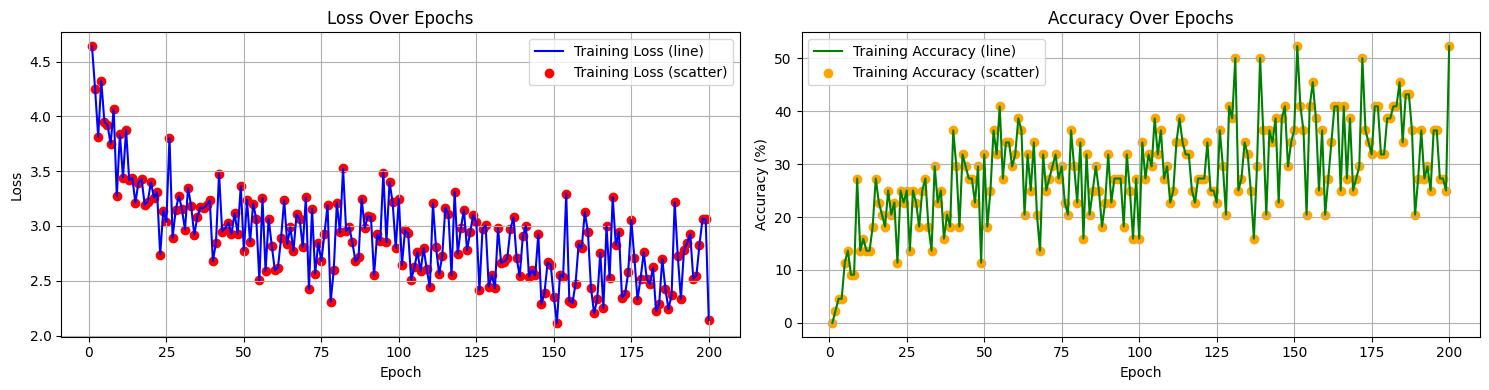

In [47]:
import matplotlib.pyplot as plt

def plot_losses_together(losses, accuracies):
    """Plots training losses and accuracies with line and scatter in one figure"""
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # 2x1 grid of subplots

    # Loss plot (line and scatter on the same axes)
    epochs = range(1, len(losses) + 1)
    axs[0].plot(epochs, losses, label='Training Loss (line)', color='blue', linestyle='-')
    axs[0].scatter(epochs, losses, color='red', label='Training Loss (scatter)')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)
    axs[0].legend()

    # Accuracy plot (line and scatter on the same axes)
    axs[1].plot(epochs, accuracies, label='Training Accuracy (line)', color='green', linestyle='-')
    axs[1].scatter(epochs, accuracies, color='orange', label='Training Accuracy (scatter)')
    axs[1].set_title('Accuracy Over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage with sample data (you can replace these with your actual `epoch_losses` and `epoch_accuracies` lists)
plot_losses_together(epoch_losses, epoch_accuracies)


# **Loss curve using different charts**

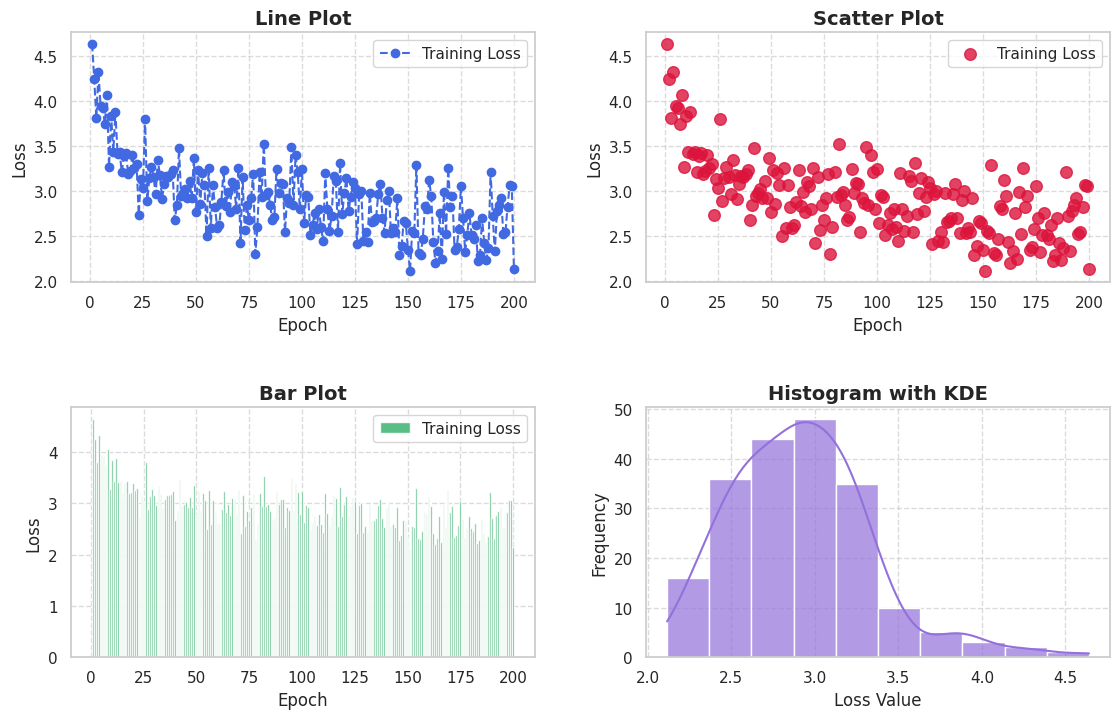

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more attractive style using seaborn
sns.set(style="whitegrid")

# Plotting function for training losses with different chart styles
def plot_losses_together(losses):
    """Plots training losses using different types of plots with enhanced visuals"""
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid of subplots

    # Line plot with markers
    axs[0, 0].plot(range(1, len(losses) + 1), losses, label='Training Loss', color='royalblue', marker='o', markersize=6, linestyle='--')
    axs[0, 0].set_title('Line Plot', fontsize=14, fontweight='bold')
    axs[0, 0].set_xlabel('Epoch', fontsize=12)
    axs[0, 0].set_ylabel('Loss', fontsize=12)
    axs[0, 0].legend(loc='best')
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Scatter plot with larger markers
    axs[0, 1].scatter(range(1, len(losses) + 1), losses, label='Training Loss', color='crimson', s=70, alpha=0.8)
    axs[0, 1].set_title('Scatter Plot', fontsize=14, fontweight='bold')
    axs[0, 1].set_xlabel('Epoch', fontsize=12)
    axs[0, 1].set_ylabel('Loss', fontsize=12)
    axs[0, 1].legend(loc='best')
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Bar plot with alpha transparency
    axs[1, 0].bar(range(1, len(losses) + 1), losses, label='Training Loss', color='mediumseagreen', alpha=0.85)
    axs[1, 0].set_title('Bar Plot', fontsize=14, fontweight='bold')
    axs[1, 0].set_xlabel('Epoch', fontsize=12)
    axs[1, 0].set_ylabel('Loss', fontsize=12)
    axs[1, 0].legend(loc='best')
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Histogram plot with KDE overlay
    sns.histplot(losses, bins=10, kde=True, color='mediumpurple', ax=axs[1, 1], alpha=0.7)
    axs[1, 1].set_title('Histogram with KDE', fontsize=14, fontweight='bold')
    axs[1, 1].set_xlabel('Loss Value', fontsize=12)
    axs[1, 1].set_ylabel('Frequency', fontsize=12)
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout(pad=3.0)
    plt.show()

plot_losses_together(epoch_losses)

# **Accuracy curve using different graphs**

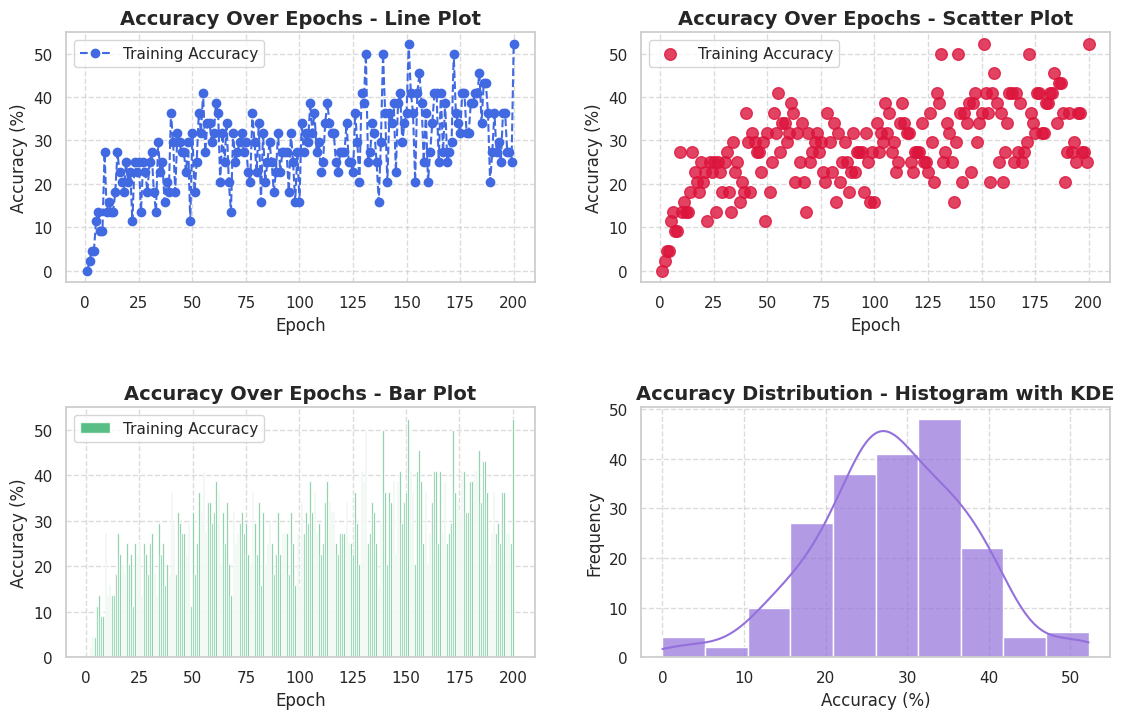

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set an attractive style using seaborn
sns.set(style="whitegrid")

# Enhanced plotting function for accuracies with multiple plot types in one frame
def plot_accuracies_together(accuracies):
    """
    Plots training accuracies using different types of plots with enhanced visuals
    Args:
    accuracies: List of accuracy values to plot for each epoch
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid of subplots, larger size

    # Line plot with markers for accuracy
    axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label='Training Accuracy', color='royalblue', marker='o', markersize=6, linestyle='--')
    axs[0, 0].set_title('Accuracy Over Epochs - Line Plot', fontsize=14, fontweight='bold')
    axs[0, 0].set_xlabel('Epoch', fontsize=12)
    axs[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
    axs[0, 0].legend(loc='best')
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Scatter plot with larger markers for accuracy
    axs[0, 1].scatter(range(1, len(accuracies) + 1), accuracies, label='Training Accuracy', color='crimson', s=70, alpha=0.8)
    axs[0, 1].set_title('Accuracy Over Epochs - Scatter Plot', fontsize=14, fontweight='bold')
    axs[0, 1].set_xlabel('Epoch', fontsize=12)
    axs[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axs[0, 1].legend(loc='best')
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Bar plot for accuracy
    axs[1, 0].bar(range(1, len(accuracies) + 1), accuracies, label='Training Accuracy', color='mediumseagreen', alpha=0.85)
    axs[1, 0].set_title('Accuracy Over Epochs - Bar Plot', fontsize=14, fontweight='bold')
    axs[1, 0].set_xlabel('Epoch', fontsize=12)
    axs[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
    axs[1, 0].legend(loc='best')
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Histogram plot with KDE for accuracy distribution
    sns.histplot(accuracies, bins=10, kde=True, color='mediumpurple', ax=axs[1, 1], alpha=0.7)
    axs[1, 1].set_title('Accuracy Distribution - Histogram with KDE', fontsize=14, fontweight='bold')
    axs[1, 1].set_xlabel('Accuracy (%)', fontsize=12)
    axs[1, 1].set_ylabel('Frequency', fontsize=12)
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout(pad=3.0)
    plt.show()

# Example usage: Replace accuracies with your actual accuracy data from training
# accuracies = [80, 85, 88, 90, 92, 93, 94, 95, 96, 97]  # Replace this with your accuracy data
plot_accuracies_together(epoch_accuracies)
